# FCN3 Model Output Visualization

This notebook loads a trained FCN3 network and visualizes its output against target values.

## Section 1: Import Required Libraries

Import necessary libraries including PyTorch, NumPy, Matplotlib, and dependencies for loading and plotting the model.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import sys
print(Path.cwd())
# Add lib to path for importing FCN3Network
sys.path.insert(0, str(Path.cwd().parent.parent / "lib"))

print("Libraries imported successfully!")

/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence
Libraries imported successfully!


## Section 2: Load the Model

Load the PyTorch model from the specified checkpoint path and configuration.

In [2]:
# Define model directory and paths

model_dir = Path("/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/seed42")


model_path = model_dir / "model.pt"
config_path = model_dir / "config.json"
print(f"Model directory: {model_dir}")
print(f"Model path exists: {model_path.exists()}")
print(f"Config path exists: {config_path.exists()}")


# Load configuration
with open(config_path, 'r') as f:
    cfg = json.load(f)

# cfg={"P":2138, "d":150,"kappa":2.0,"chi":10.0}

print(f"\nConfiguration: {json.dumps(cfg, indent=2)}")

# Load model state dict
from FCN3Network import FCN3NetworkActivationGeneric

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Load state dict
sd = torch.load(model_path, map_location="cpu")

# Extract dimensions from state dict
d = sd['W0'].shape[-1]
n1 = sd['W0'].shape[-2]
n2 = sd['W1'].shape[-2]
P = cfg["P"]
ens = sd['W0'].shape[0] if sd['W0'].ndim == 3 else sd['W0'].shape[1]
kappa = cfg.get("kappa", 0.1)

print(f"\nModel dimensions:")
print(f"  d (input): {d}")
print(f"  n1 (hidden 1): {n1}")
print(f"  n2 (hidden 2): {n2}")
print(f"  P (samples): {P}")
print(f"  ens (ensembles): {ens}")

# Initialize and load model
model = FCN3NetworkActivationGeneric(
    d=d, n1=n1, n2=n2, P=P, ens=ens, activation="erf",
    weight_initialization_variance=(1.0/d, 1.0/n1, 1.0/(n1*n2)),
    device=device
)

# Handle state dict loading with potential dimension squeezed
model.load_state_dict({k: v.squeeze(0) if v.ndim > (3 if 'W' in k else 2) else v for k, v in sd.items()}, strict=False)
model = model.to(device)
model.eval()

print("\nModel loaded successfully!")

Model directory: /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/seed42
Model path exists: True
Config path exists: True

Configuration: {
  "d": 150,
  "P": 3000,
  "N": 1600,
  "kappa": 0.1,
  "lr": 3.3333333333333333e-06,
  "epochs": 30000000,
  "chi": 50,
  "seed": 42,
  "ens": 5,
  "current_epoch": 25100000
}

Using device: cuda:0

Model dimensions:
  d (input): 150
  n1 (hidden 1): 1600
  n2 (hidden 2): 1600
  P (samples): 3000
  ens (ensembles): 5

Model loaded successfully!


In [3]:
model.W0.shape

torch.Size([5, 1600, 150])

In [4]:
W0 = model.W0.detach()  # shape: (num_seeds, ens, N, d)
W0_reshaped = W0.view(model.ens * 1 * 1600, d)  # shape: (num_seeds*ens*N, d)
cov_W0 = torch.matmul(W0_reshaped.t(), W0_reshaped) / (1 * 1600)
W0_vars = torch.linalg.eigvalsh(cov_W0).sort(descending=True).values.cpu().numpy()
W0_var_max = W0_vars[0]
print(f"\nMax eigenvalue of W0 covariance: {W0_var_max:.4f}")


Max eigenvalue of W0 covariance: 0.0959


In [5]:
eigenvalues, eigenvectors = torch.linalg.eigh(cov_W0)
print(f"Top eigenvalue of W0 covariance: {eigenvalues[-1].item():.4f}")
print(f"Corresponding eigenvector (first 10 components): {eigenvectors[:, -1][:10].cpu().numpy()}")

Top eigenvalue of W0 covariance: 0.0959
Corresponding eigenvector (first 10 components): [ 9.9723357e-01 -2.0993510e-04  4.2362465e-03  4.7364407e-03
 -5.7603593e-04 -7.4628559e-03  4.1849855e-03  1.6981133e-03
  2.1359059e-03 -7.5178179e-03]


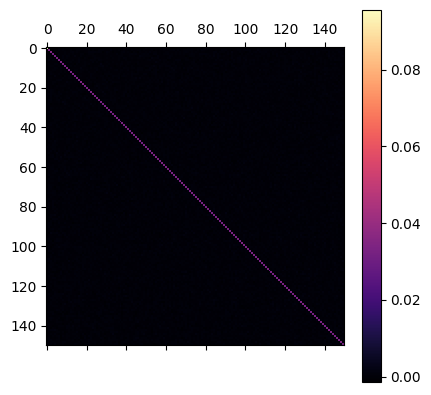

In [6]:
plt.matshow(cov_W0.cpu().numpy(), cmap='magma')
plt.colorbar()
plt.show()

In [7]:
one_hot_d = torch.eye(d, device=device)[0,:]
one_hot_d.T @ cov_W0 @ one_hot_d

/tmp/ipykernel_551818/846452673.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  one_hot_d.T @ cov_W0 @ one_hot_d


tensor(0.0956, device='cuda:0')

In [8]:
from scipy import stats

# 1. Prepare data
w0_flat = model.W0.detach().cpu().numpy()[:, :, 0].ravel()
alpha = 0.05

# 2. D'Agostino-Pearson test
k2_stat, k2_p = stats.normaltest(w0_flat)
dp_outcome = "Normal" if k2_p > alpha else "Not Normal"

# 3. Anderson-Darling test
ad_result = stats.anderson(w0_flat, dist="norm")

# --- Display Results ---
print(f"Sample size: {w0_flat.size}")
print("-" * 30)

# D'Agostino-Pearson Outcome
print(f"D'Agostino-Pearson Test:")
print(f"  - K^2 Statistic: {k2_stat:.6f}")
print(f"  - p-value: {k2_p:.6e}")
print(f"  - Outcome (alpha={alpha}): {dp_outcome}")
print("-" * 30)

# Anderson-Darling Outcome
print("Anderson-Darling Test:")
print(f"  - Statistic: {ad_result.statistic:.6f}")
for i in range(len(ad_result.critical_values)):
    sl, cv = ad_result.significance_level[i], ad_result.critical_values[i]
    # If the statistic is less than the critical value, fail to reject H0 (Normal)
    outcome = "Normal" if ad_result.statistic < cv else "Not Normal"
    print(f"  - Significance Level {sl}%: Critical Value {cv}, Outcome: {outcome}")

Sample size: 8000
------------------------------
D'Agostino-Pearson Test:
  - K^2 Statistic: 254.538956
  - p-value: 0.000000e+00
  - Outcome (alpha=0.05): Not Normal
------------------------------
Anderson-Darling Test:
  - Statistic: 12.616456
  - Significance Level 15.0%: Critical Value 0.576, Outcome: Not Normal
  - Significance Level 10.0%: Critical Value 0.656, Outcome: Not Normal
  - Significance Level 5.0%: Critical Value 0.787, Outcome: Not Normal
  - Significance Level 2.5%: Critical Value 0.918, Outcome: Not Normal
  - Significance Level 1.0%: Critical Value 1.091, Outcome: Not Normal


<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_551818/2177977275.py:29: SyntaxWarning: invalid escape sequence '\m'
  axes[i].plot(x, p, 'r', linewidth=2, label=f'Normal PDF\n$\mu$={mu:.4f}, $\sigma^2$={std**2:.4f}')
/tmp/ipykernel_551818/2177977275.py:29: SyntaxWarning: invalid escape sequence '\s'
  axes[i].plot(x, p, 'r', linewidth=2, label=f'Normal PDF\n$\mu$={mu:.4f}, $\sigma^2$={std**2:.4f}')


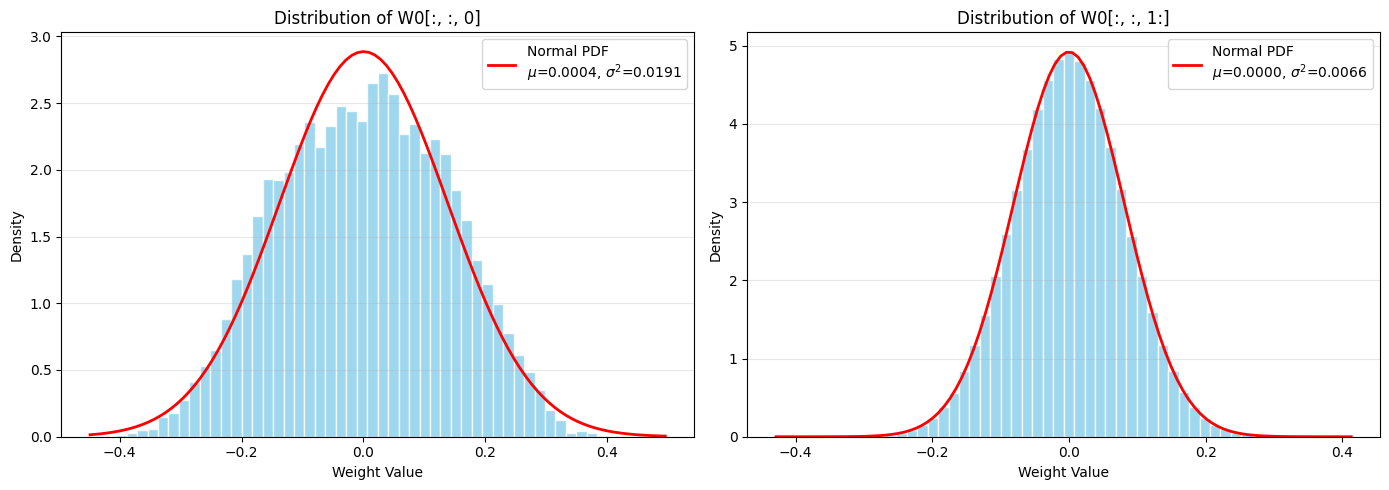

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# 1. Prepare the data slices
# Slice 1: All rows, all columns, first depth index
data1 = model.W0.detach().cpu().numpy()[:, :, 0].ravel()
# Slice 2: All rows, all columns, remaining depth indices
data2 = model.W0.detach().cpu().numpy()[:, :, 1:].ravel()

datasets = [data1, data2]
titles = ["Distribution of W0[:, :, 0]", "Distribution of W0[:, :, 1:]"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, data in enumerate(datasets):
    # Calculate stats for the Gaussian curve
    mu, std = np.mean(data), np.std(data)
    
    # Plot the histogram (density=True is required to match the PDF scale)
    axes[i].hist(data, bins=50, density=True, alpha=0.8, color='skyblue', edgecolor='white')
    
    # Generate points for the PDF curve
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    
    # Overlay the Normal PDF
    axes[i].plot(x, p, 'r', linewidth=2, label=f'Normal PDF\n$\mu$={mu:.4f}, $\sigma^2$={std**2:.4f}')
    
    # Formatting
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Weight Value")
    axes[i].set_ylabel("Density")
    axes[i].legend()
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Section 3: Load the Data and Target

For this model trained on synthetic data, we generate test data and targets. We'll create both random test data and the original training data distribution.

In [10]:
cfg

{'d': 150,
 'P': 3000,
 'N': 1600,
 'kappa': 0.1,
 'lr': 3.3333333333333333e-06,
 'epochs': 30000000,
 'chi': 50,
 'seed': 42,
 'ens': 5,
 'current_epoch': 25100000}

In [11]:
# Generate synthetic test data and targets
# For this problem, we'll create a dataset where the model has been trained
# We use the same random seed as the training to get consistent data

torch.manual_seed(cfg['seed'])
np.random.seed(cfg['seed'])

# Number of test samples to generate
num_test_samples = cfg['P']

# Generate random input data from standard normal distribution
X_test = torch.randn(num_test_samples, d, device=device)

# Generate synthetic target data
# The model learns a function that maps d-dimensional inputs to n2-dimensional outputs averaged over ensemble
# We create a target based on a known function
torch.manual_seed(cfg['seed'] + 100)  # Different seed for targets
y_target = X_test[:,0] + 0.03 * (X_test[:,0]**3 - 3 * X_test[:,0])

In [12]:
model.W0.shape

torch.Size([5, 1600, 150])

In [13]:
W0 = model.W0.detach()  # shape: (num_seeds, ens, N, d)
W0_reshaped = W0.view(model.ens * model.n1 * 1, d)  # shape: (num_seeds*ens*N, d)
cov_W0 = torch.matmul(W0_reshaped.t(), W0_reshaped) / (5*1600)
W0_vars = torch.linalg.eigvalsh(cov_W0).sort(descending=True).values.cpu().numpy()
W0_var_max = W0_vars[0]
print(f"\nMax eigenvalue of W0 covariance: {W0_var_max:.4f}")


Max eigenvalue of W0 covariance: 0.0192


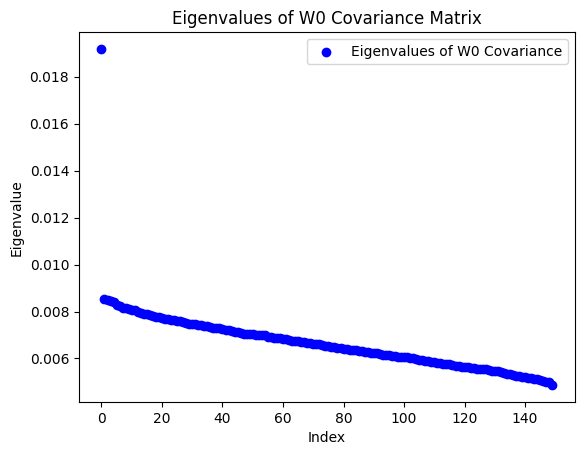

In [14]:
plt.scatter(range(len(W0_vars)), W0_vars, color='blue', label='Eigenvalues of W0 Covariance')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of W0 Covariance Matrix')
plt.legend()
plt.show()

## Section 4: Generate Model Predictions

Use the loaded model to generate predictions on the test data with appropriate batching.

In [15]:
y_pred.shape

NameError: name 'y_pred' is not defined

In [16]:
# Generate model predictions with batching for memory efficiency
torch.manual_seed(cfg['seed'])
batch_size = 100
y_pred_list = []

with torch.no_grad():
    for i in range(0, num_test_samples, batch_size):
        batch_end = min(i + batch_size, num_test_samples)
        X_batch = X_test[i:batch_end]
        y_batch = model(X_batch)  # shape: (batch_size, ens)
        y_pred_list.append(y_batch)

# Concatenate all predictions
y_pred = torch.cat(y_pred_list, dim=0)  # shape: (num_test_samples, ens)

print(f"Generated predictions:")
print(f"  y_pred shape: {y_pred.shape}")
print(f"  y_pred mean: {y_pred.mean():.4f}, std: {y_pred.std():.4f}")

# Move to CPU for plotting
y_pred_np = y_pred.detach().cpu().numpy()
y_target_np = y_target.detach().cpu().numpy()
X_test_np = X_test.detach().cpu().numpy()

Generated predictions:
  y_pred shape: torch.Size([3000, 5])
  y_pred mean: 0.0244, std: 1.0187


## Section 5: Create Comparison Plots

Create comprehensive visualizations comparing model predictions against target values.

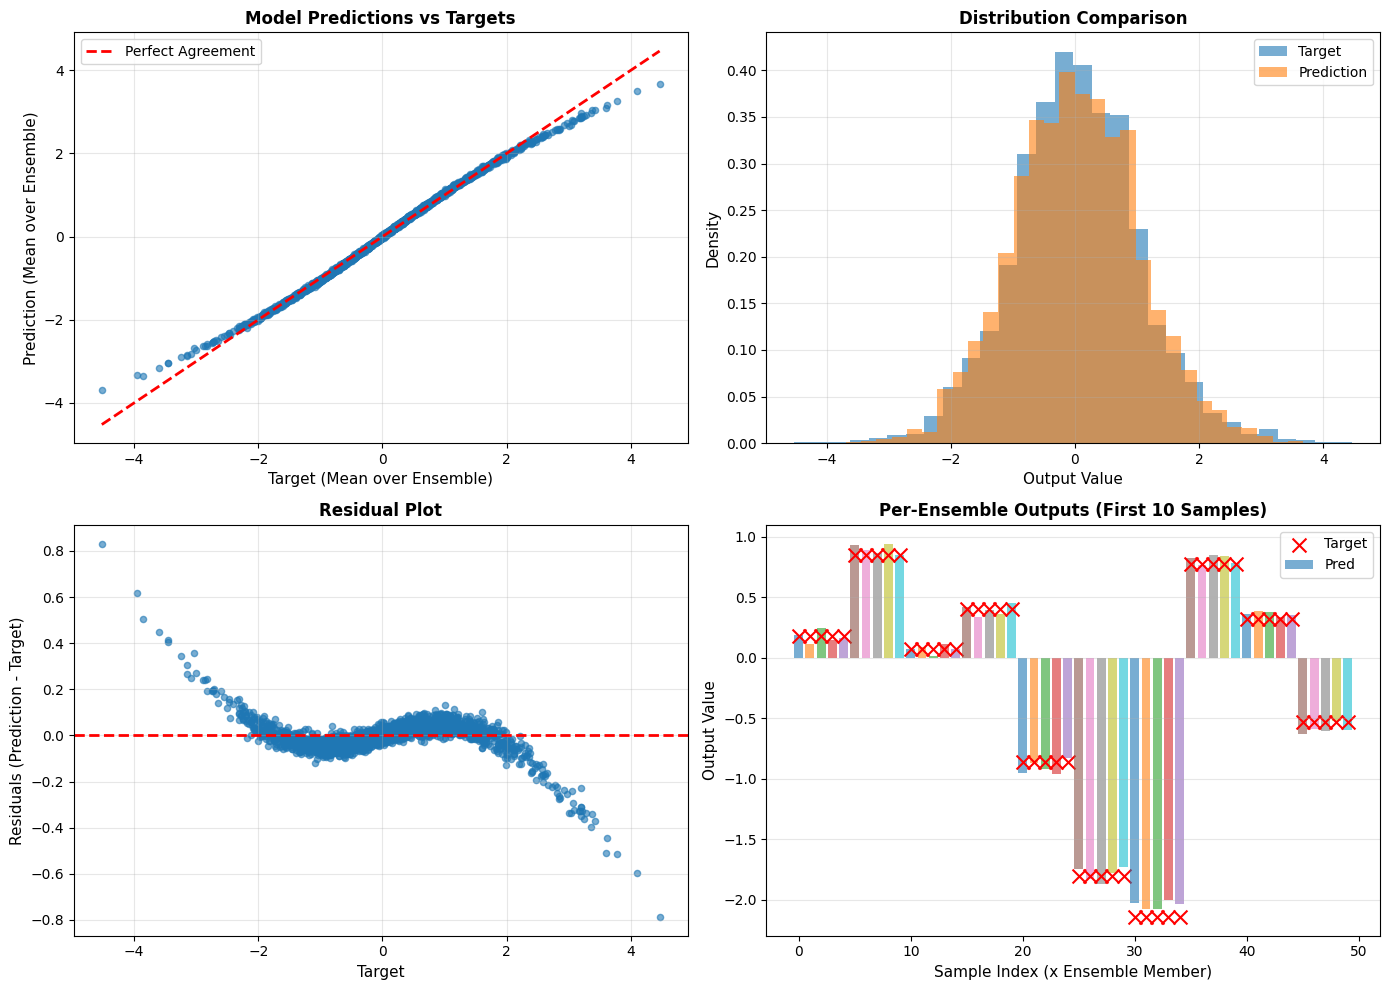

Plot saved to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/seed42/model_output_comparison.png


In [17]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Prediction vs Target Scatter (Average over ensembles)
ax = axes[0, 0]
y_pred_mean = y_pred_np.mean(axis=1)
y_target_mean = y_target_np
ax.scatter(y_target_mean, y_pred_mean, alpha=0.6, s=20)
ax.plot([y_target_mean.min(), y_target_mean.max()], 
        [y_target_mean.min(), y_target_mean.max()], 
        'r--', lw=2, label='Perfect Agreement')
ax.set_xlabel('Target (Mean over Ensemble)', fontsize=11)
ax.set_ylabel('Prediction (Mean over Ensemble)', fontsize=11)
ax.set_title('Model Predictions vs Targets', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Distribution comparison
ax = axes[0, 1]
ax.hist(y_target_mean, bins=30, alpha=0.6, label='Target', density=True)
ax.hist(y_pred_mean, bins=30, alpha=0.6, label='Prediction', density=True)
ax.set_xlabel('Output Value', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Distribution Comparison', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Residuals
ax = axes[1, 0]
residuals = y_pred_mean - y_target_mean
ax.scatter(y_target_mean, residuals, alpha=0.6, s=20)
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Target', fontsize=11)
ax.set_ylabel('Residuals (Prediction - Target)', fontsize=11)
ax.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: Per-ensemble outputs (first 5 samples)
ax = axes[1, 1]
sample_indices = np.arange(min(10, num_test_samples))
x_pos = np.arange(len(sample_indices) * ens)
for i, idx in enumerate(sample_indices):
    for e in range(ens):
        x = i * ens + e
        ax.bar(x, y_pred_np[idx, e], alpha=0.6, label='Pred' if e == 0 and i == 0 else '')
        ax.scatter(x, y_target_np[idx], color='red', s=100, marker='x', 
                  label='Target' if e == 0 and i == 0 else '')

ax.set_xlabel('Sample Index (x Ensemble Member)', fontsize=11)
ax.set_ylabel('Output Value', fontsize=11)
ax.set_title('Per-Ensemble Outputs (First 10 Samples)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(model_dir / 'model_output_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot saved to {model_dir / 'model_output_comparison.png'}")

In [18]:
h3_component = y_pred_np[sort_idx, :].mean(axis=1) - (y_pred_np[sort_idx, :].mean(axis=1) @ X_test_np[sort_idx, 0] / X_test_np.shape[0]) * X_test_np[sort_idx, 0]
he3 = (X_test_np[sort_idx,0]**3 - 3 * X_test_np[sort_idx,0]) / 6**0.5
he3 @ h3_component / X_test_np.shape[0] / (0.03 * 6**0.5)

NameError: name 'sort_idx' is not defined

In [19]:
cfg['seed']

42

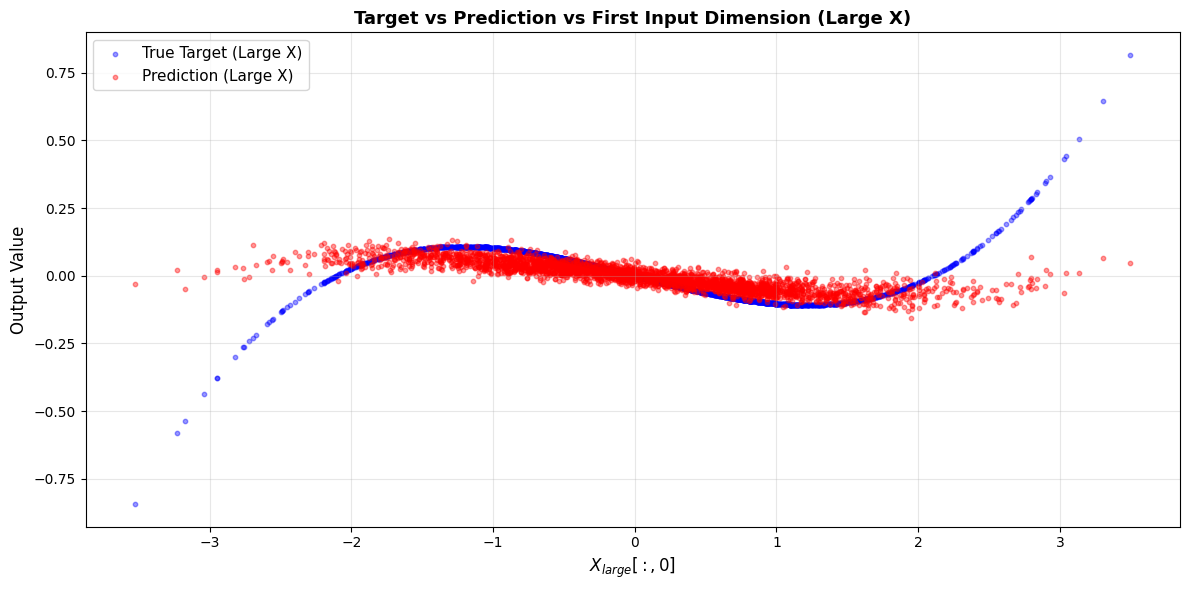

Plot saved to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/seed42/target_vs_prediction_vs_x0_large.png


In [20]:
# Plot target and prediction against X_large[:, 0]
torch.manual_seed(cfg['seed'])

X_large = torch.randn(cfg['P'], d, device=device)
y_pred_large = model(X_large)  .mean(dim=1)  # Average over ensembles 
X_large_np = X_large.detach().cpu().numpy()
y_pred_large_np = y_pred_large.detach().cpu().numpy()

# Compute target for large X using the same synthetic function
x0_large = X_large_np[:, 0]
y_target_large = x0_large + 0.03 * (x0_large**3 - 3 * x0_large)

# Sort by X_large[:,0] for better visualization
sort_idx_large = np.argsort(x0_large)
x_large_sorted = x0_large[sort_idx_large]

# Center target and prediction around x0 for visualization
y_target_large_sorted = (
    y_target_large[sort_idx_large]
   - (y_target_large[sort_idx_large] @ x_large_sorted / x_large_sorted.shape[0]) * x_large_sorted
) 
y_pred_large_sorted = (
    y_pred_large_np[sort_idx_large]
   - (y_pred_large_np[sort_idx_large] @ x_large_sorted / x_large_sorted.shape[0]) * x_large_sorted
)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x_large_sorted, y_target_large_sorted, alpha=0.4, s=10, label='True Target (Large X)', color='blue')
ax.scatter(x_large_sorted, y_pred_large_sorted, alpha=0.4, s=10, label='Prediction (Large X)', color='red')

ax.set_xlabel(r'$X_{large}[:,0]$', fontsize=12)
ax.set_ylabel('Output Value', fontsize=12)
ax.set_title('Target vs Prediction vs First Input Dimension (Large X)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(model_dir / 'target_vs_prediction_vs_x0_large.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot saved to {model_dir / 'target_vs_prediction_vs_x0_large.png'}")

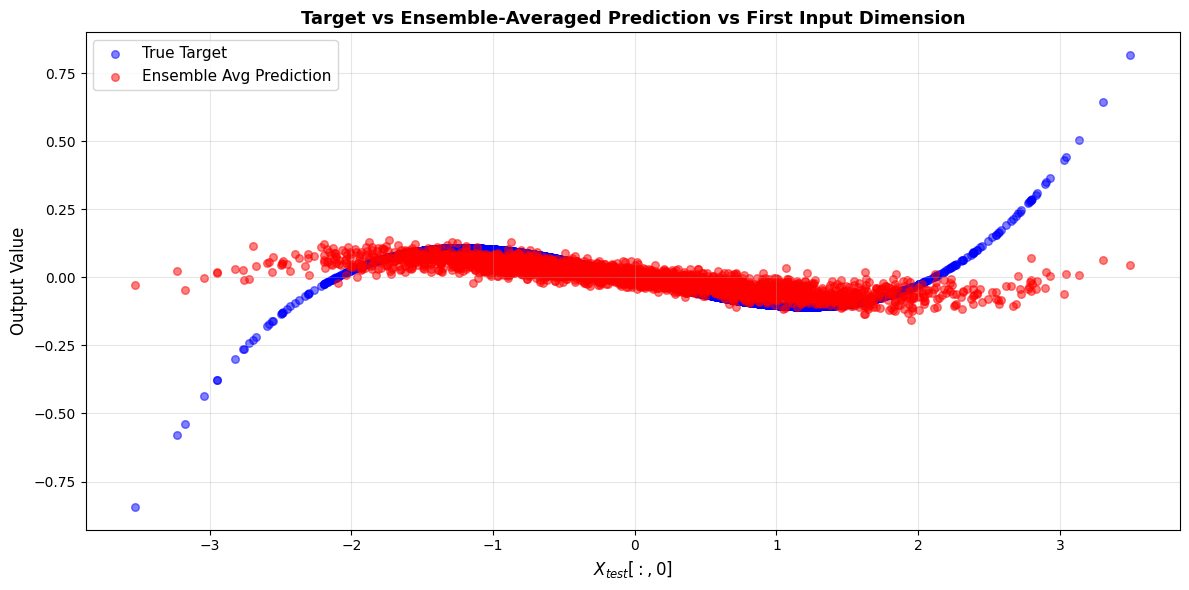

Plot saved to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/seed42/target_vs_prediction_vs_x0.png


In [21]:
# Plot target and prediction against X_test[:,0]
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by X_test[:,0] for better visualization
sort_idx = np.argsort(X_test_np[:, 0])
x_sorted = X_test_np[sort_idx, 0]
y_target_sorted = y_target_np[sort_idx] - y_target_np[sort_idx] @ X_test_np[sort_idx, 0] / X_test_np.shape[0] * X_test_np[sort_idx,0] # Center target around x for better visualization
y_pred_sorted = y_pred_np[sort_idx, :].mean(axis=1) - (y_pred_np[sort_idx, :].mean(axis=1) @ X_test_np[sort_idx, 0] / X_test_np.shape[0]) * X_test_np[sort_idx, 0]  # Center prediction around x for better visualization

# Plot both target and prediction
ax.scatter(x_sorted, y_target_sorted, alpha=0.5, s=30, label='True Target', color='blue')
ax.scatter(x_sorted, y_pred_sorted, alpha=0.5, s=30, label='Ensemble Avg Prediction', color='red')

ax.set_xlabel(r'$X_{test}[:,0]$', fontsize=12)
ax.set_ylabel('Output Value', fontsize=12)
ax.set_title('Target vs Ensemble-Averaged Prediction vs First Input Dimension', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(model_dir / 'target_vs_prediction_vs_x0.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot saved to {model_dir / 'target_vs_prediction_vs_x0.png'}")

## Section 6: Calculate Performance Metrics

Compute quantitative performance metrics to evaluate model accuracy.

## Section 5b: Target vs Prediction vs First Input Dimension

Plot the true target and ensemble-averaged prediction as a function of the first input dimension X_test[:,0].

In [22]:
#Large P prediction
torch.manual_seed(cfg['seed'])
X_large = torch.randn(3000, d, device=device)
y_pred_large = model(X_large).mean(dim=1)
linear_proj = ((y_pred_large).T @ (X_large[:,0])) / (10000)
cubic_proj = ((y_pred_large - X_large[:,0]).T @ (X_large[:,0]**3 - 3 * X_large[:,0])) / (10000)

[Random Omega generation] 0.0000s
[  res chunk [0:3000]] 0.0152s
[res computation (chunks of 4096)] 0.0251s
[QR factorisation] 0.1408s
[  Z chunk [0:3000]] 0.0300s
[Z computation (chunks of 4096)] 0.0372s
[B = Q.T @ Z] 0.0001s
[eigvalsh] 0.1761s
[final sort] 0.0125s


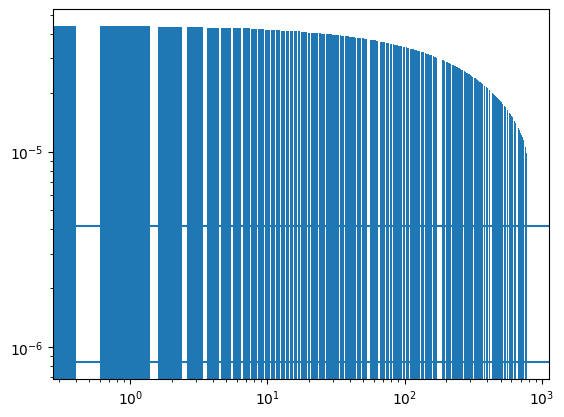

In [23]:
He3 = (X_large**3 - 3 * X_large) / 6**0.5
He3 = (X_large**3 - 3 * X_large) / 6**0.5
eigs = model.H_eig_random_svd(X_large, k=900)
lh3 = eigs[150].item()
eta3 = lh3 / (lh3 + 0.01 / 3000) 
s,f = 150,9000
plt.bar(list(range(eigs[s:f].shape[0])),eigs[s:f].detach().cpu().numpy())
plt.yscale('log')
plt.xscale('log')
plt.axhline(y = 2.5e-5/6)
plt.axhline(y = 8.38e-7)
# plt.axhline(y=0.00282)
# plt.axhline(y=0.018)

In [24]:
model.H_eig(X_large, He3).sort(descending=True)[0]

tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 

In [25]:
model.H_eig_random_svd(X_test, k=400)[model.d:]

[Random Omega generation] 0.0000s
[  res chunk [0:3000]] 0.0176s
[res computation (chunks of 4096)] 0.0314s
[QR factorisation] 0.0106s
[  Z chunk [0:3000]] 0.0184s
[Z computation (chunks of 4096)] 0.0316s
[B = Q.T @ Z] 0.0001s
[eigvalsh] 0.1379s
[final sort] 0.0134s


tensor([3.9366e-05, 3.8821e-05, 3.8360e-05, 3.8292e-05, 3.8080e-05, 3.7903e-05,
        3.7696e-05, 3.7385e-05, 3.7293e-05, 3.7132e-05, 3.7048e-05, 3.6773e-05,
        3.6558e-05, 3.6393e-05, 3.6223e-05, 3.6087e-05, 3.6014e-05, 3.5973e-05,
        3.5748e-05, 3.5531e-05, 3.5479e-05, 3.5373e-05, 3.5196e-05, 3.4942e-05,
        3.4916e-05, 3.4903e-05, 3.4764e-05, 3.4693e-05, 3.4421e-05, 3.4376e-05,
        3.4310e-05, 3.4146e-05, 3.4079e-05, 3.4025e-05, 3.3934e-05, 3.3798e-05,
        3.3731e-05, 3.3615e-05, 3.3545e-05, 3.3522e-05, 3.3339e-05, 3.3283e-05,
        3.3212e-05, 3.3072e-05, 3.2951e-05, 3.2837e-05, 3.2765e-05, 3.2635e-05,
        3.2560e-05, 3.2512e-05, 3.2464e-05, 3.2351e-05, 3.2271e-05, 3.2078e-05,
        3.2030e-05, 3.1963e-05, 3.1872e-05, 3.1814e-05, 3.1701e-05, 3.1671e-05,
        3.1652e-05, 3.1423e-05, 3.1314e-05, 3.1247e-05, 3.1199e-05, 3.1139e-05,
        3.1003e-05, 3.0960e-05, 3.0892e-05, 3.0835e-05, 3.0759e-05, 3.0668e-05,
        3.0504e-05, 3.0461e-05, 3.0398e-

In [26]:
ens

5

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics (using ensemble mean)
y_pred_mean = y_pred_np.mean(axis=1)
y_target_mean = y_target_np

mse = mean_squared_error(y_target_mean, y_pred_mean)
mae = mean_absolute_error(y_target_mean, y_pred_mean)
r2 = r2_score(y_target_mean, y_pred_mean)
rmse = np.sqrt(mse)

# Also calculate per-ensemble metrics
mse_per_ens = []
mae_per_ens = []
r2_per_ens = []

for e in range(ens):
    mse_e = mean_squared_error(y_target_np, y_pred_np[:, e])
    mae_e = mean_absolute_error(y_target_np, y_pred_np[:, e])
    r2_e = r2_score(y_target_np, y_pred_np[:, e])
    mse_per_ens.append(mse_e)
    mae_per_ens.append(mae_e)
    r2_per_ens.append(r2_e)

# Print results
print("=" * 60)
print("PERFORMANCE METRICS (Ensemble Mean)")
print("=" * 60)
print(f"Mean Squared Error (MSE):  {mse:.6f}")
print(f"Root Mean Squared Error:   {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score:                  {r2:.6f}")
print()
print("=" * 60)
print("PER-ENSEMBLE METRICS")
print("=" * 60)
for e in range(ens):
    print(f"Ensemble {e}:")
    print(f"  MSE: {mse_per_ens[e]:.6f}, MAE: {mae_per_ens[e]:.6f}, R²: {r2_per_ens[e]:.6f}")

print()
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"Target range: [{y_target_mean.min():.4f}, {y_target_mean.max():.4f}]")
print(f"Prediction range: [{y_pred_mean.min():.4f}, {y_pred_mean.max():.4f}]")
print(f"Target std: {y_target_mean.std():.4f}")
print(f"Prediction std: {y_pred_mean.std():.4f}")
print(f"Residual std: {residuals.std():.4f}")
print("=" * 60)

PERFORMANCE METRICS (Ensemble Mean)
Mean Squared Error (MSE):  0.004071
Root Mean Squared Error:   0.063802
Mean Absolute Error (MAE): 0.039120
R² Score:                  0.996128

PER-ENSEMBLE METRICS
Ensemble 0:
  MSE: 0.005265, MAE: 0.048562, R²: 0.994991
Ensemble 1:
  MSE: 0.005280, MAE: 0.048303, R²: 0.994978
Ensemble 2:
  MSE: 0.005311, MAE: 0.048452, R²: 0.994948
Ensemble 3:
  MSE: 0.005154, MAE: 0.048251, R²: 0.995097
Ensemble 4:
  MSE: 0.005176, MAE: 0.048485, R²: 0.995076

SUMMARY STATISTICS
Target range: [-4.5196, 4.4632]
Prediction range: [-3.6874, 3.6756]
Target std: 1.0253
Prediction std: 1.0181
Residual std: 0.0638


Found 1 seed directories

Processing seed42...
42 /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/seed42/model.pt
  Predictions shape: (3000,)


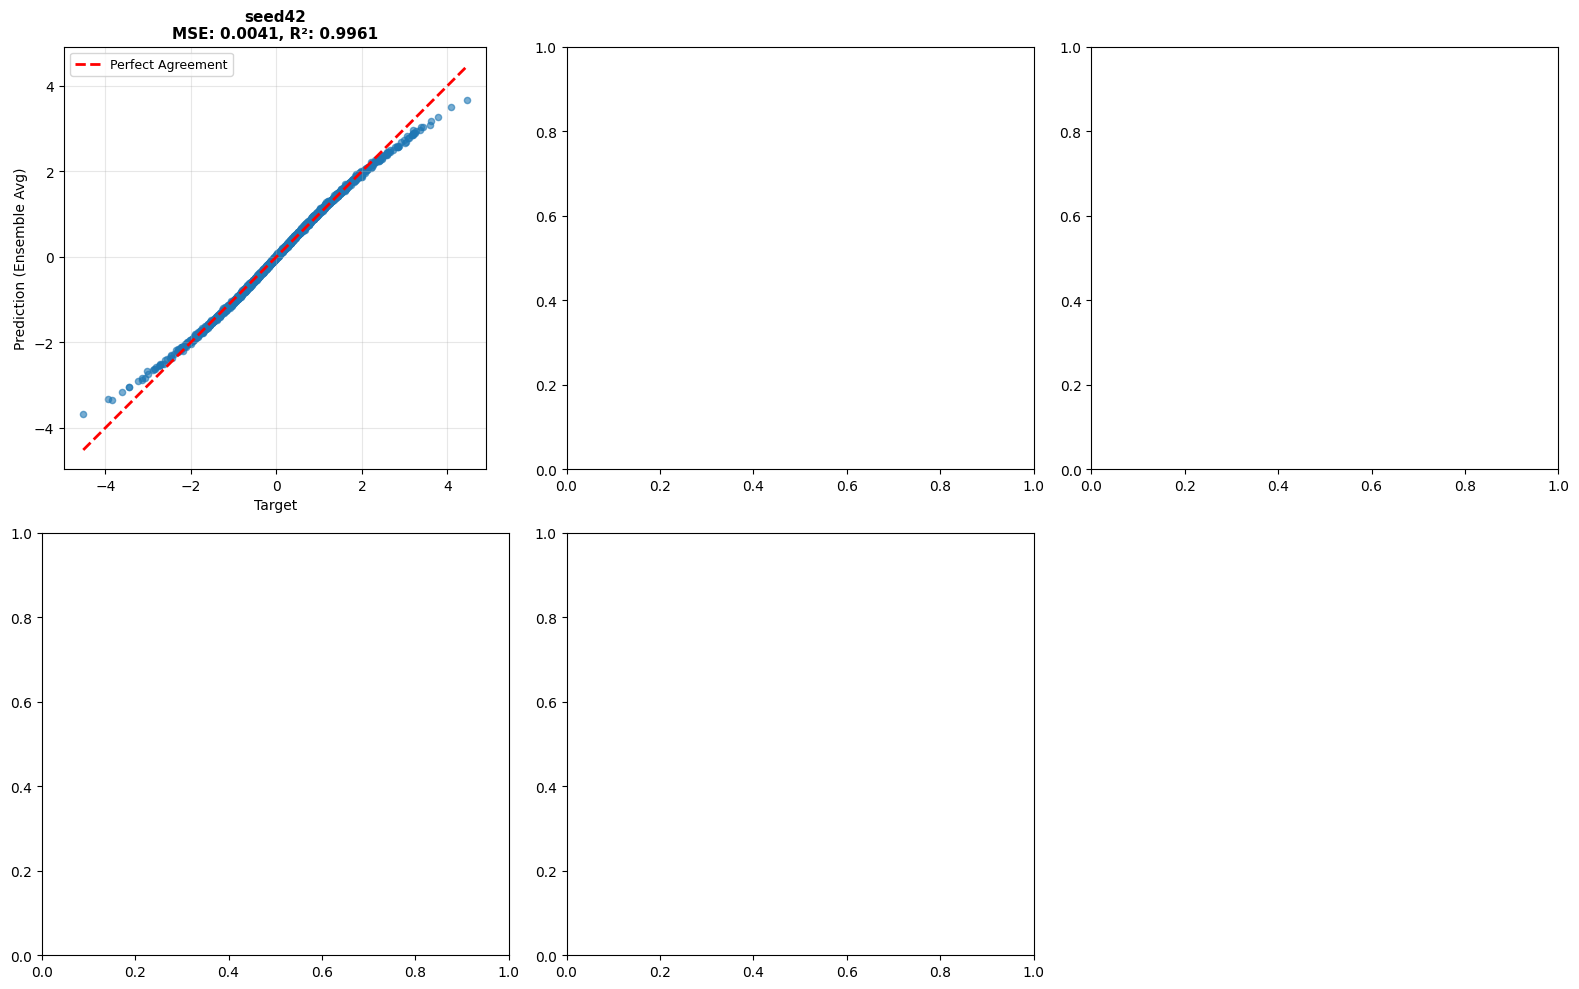


Plot saved to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/all_seeds_predictions_vs_targets.png


In [28]:
# Load models for all seeds and compare predictions vs targets
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import json

# Define base directory and get all seed directories
# base_dir = Path("/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/P_scan_KAPPA0.1_FINALIZED/d150_P1105_N1600_chi10_kappa0.1/")
base_dir = Path("/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/")
seed_dirs = sorted([d for d in base_dir.iterdir() if d.is_dir() and d.name.startswith("seed")])

print(f"Found {len(seed_dirs)} seed directories")

# Store predictions and targets for all seeds
all_predictions = {}
all_targets = {}

# Load models and generate predictions for each seed
for seed_dir in seed_dirs:
    model_path = seed_dir / "model.pt"
    config_path = seed_dir / "config.json"
    
    if not model_path.exists() or not config_path.exists():
        print(f"Skipping {seed_dir.name}: missing model or config")
        continue
    
    print(f"\nProcessing {seed_dir.name}...")
    
    # Load configuration
    with open(config_path, 'r') as f:
        cfg_seed = json.load(f)
    
    # Load state dict
    sd_seed = torch.load(model_path, map_location="cpu")
    
    # Extract dimensions
    d_seed = sd_seed['W0'].shape[-1]
    n1_seed = sd_seed['W0'].shape[-2]
    n2_seed = sd_seed['W1'].shape[-2]
    P_seed = cfg_seed["P"]
    ens_seed = sd_seed['W0'].shape[0] if sd_seed['W0'].ndim == 3 else sd_seed['W0'].shape[1]
    
    # Initialize model
    model_seed = FCN3NetworkActivationGeneric(
        d=d_seed, n1=n1_seed, n2=n2_seed, P=P_seed, ens=ens_seed, activation="erf",
        weight_initialization_variance=(1.0/d_seed, 1.0/n1_seed, 1.0/(n1_seed*n2_seed)),
        device=device
    )
    
    # Load state dict
    model_seed.load_state_dict({k: v.squeeze(0) if v.ndim > (3 if 'W' in k else 2) else v for k, v in sd_seed.items()}, strict=False)
    model_seed = model_seed.to(device)
    model_seed.eval()
    
    # Generate predictions with batching
    batch_size = 100
    y_pred_list = []
    torch.manual_seed(cfg_seed['seed'])
    print(cfg_seed['seed'], model_path)
    X_test = torch.randn(num_test_samples, d_seed, device=device)  # Generate test inputs with same seed-based generation
    with torch.no_grad():
        for i in range(0, num_test_samples, batch_size):
            batch_end = min(i + batch_size, num_test_samples)
            X_batch = X_test[i:batch_end]
            y_batch = model_seed(X_batch)
            y_pred_list.append(y_batch)
    
    y_pred_seed = torch.cat(y_pred_list, dim=0).detach().cpu().numpy()
    
    # Store predictions (average over ensembles)
    all_predictions[seed_dir.name] = y_pred_seed.mean(axis=1)
    
    # Generate and store targets (using same seed-based generation)

    y_target_seed = X_test[:, 0] + 0.03 * (X_test[:, 0]**3 - 3 * X_test[:, 0])
    all_targets[seed_dir.name] = y_target_seed.detach().cpu().numpy()
    
    print(f"  Predictions shape: {y_pred_seed.mean(axis=1).shape}")

# Create comparison plot for all seeds
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (seed_name, y_pred_seed) in enumerate(all_predictions.items()):
    y_target_seed = all_targets[seed_name]
    
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(y_target_seed, y_pred_seed, alpha=0.6, s=20, color=f'C{idx}')
    
    # Perfect agreement line
    min_val = min(y_target_seed.min(), y_pred_seed.min())
    max_val = max(y_target_seed.max(), y_pred_seed.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Agreement')
    
    # Calculate metrics
    mse = np.mean((y_target_seed - y_pred_seed)**2)
    r2 = 1 - (np.sum((y_target_seed - y_pred_seed)**2) / np.sum((y_target_seed - y_target_seed.mean())**2))
    
    ax.set_xlabel('Target', fontsize=10)
    ax.set_ylabel('Prediction (Ensemble Avg)', fontsize=10)
    ax.set_title(f'{seed_name}\nMSE: {mse:.4f}, R²: {r2:.4f}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

# Hide the last subplot if there are fewer than 6 seeds
if len(all_predictions) < 6:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.savefig(base_dir / 'all_seeds_predictions_vs_targets.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to {base_dir / 'all_seeds_predictions_vs_targets.png'}")

## Section 7: Compare EK Predictions vs Theory

Compare theoretical EK predictions against empirical predictions computed from model eigenvalues across all seeds.

In [29]:
seed_dirs

[PosixPath('/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/seed42')]

In [30]:
chi = cfg['chi']
kappa = cfg['kappa']
print(f"\nChi: {chi}, Kappa: {kappa}")
n1 = model.n1
n2 = model.n2
print(f"n1: {n1}, n2: {n2}")
epsilon = 0.074



Chi: 50, Kappa: 0.1
n1: 1600, n2: 1600


In [31]:
import subprocess

print("="*70)
print("Computing FCS theory with normalized=true via eos_fcn3erf.jl...")
print("="*70)
eos_output_file = base_dir / "eos_fcn3erf_results.json"
# Build command with current parameters
cmd = [
    "julia",
    str(Path("/home/akiva/FCNX-Ensembling/julia_lib/eos_fcn3erf.jl")),
    "--d", str(d),
    "--kappa", str(kappa),
    "--epsilon", str(0.074),
    "--P", str(P),
    "--n1", str(n1),
    "--n2", str(n2),
    "--chi", str(chi),
    "--epsilon", str(epsilon),
    "--to", str(eos_output_file)
]
# Run the command
result = subprocess.run(cmd, capture_output=True, text=True, timeout=300)
print(result.stdout)
if result.returncode != 0 and result.stderr:
    print("STDERR:", result.stderr)

# Load results from JSON
if eos_output_file.exists():
    with open(eos_output_file) as f:
        eos_results = json.load(f)


Computing FCS theory with normalized=true via eos_fcn3erf.jl...
#####################################################################
##    &*&       THE GREAT FCN3-ERF EOS SOLVER            &*&.        
##                       Initializes                                 
#####################################################################

Parameters:
  d=150.0, κ=0.1, ϵ=0.074, P=3000.0
  n1=1600, n2=1600, χ=50.0, b=0.4244131815783876
  lr=1.0e-6, max_iter=6000000

-------
TARGET MODE (δ=1.0) - Semi MF Scaling Target Eigenvalues χ=50.0
lH1T: 0.02395827902126959, lH3T: 4.812349858707976e-6
lJ1T: 0.008198403183439016, lJ3T: 3.399128476122028e-6
lWT: 0.01948207
lJ1T/lWT: 0.9915287729402714
lJ3T/lWT^3: 0.16246683266249246

Learnabilities (Target):
mu1 = 0.9979453138208445
mu3 = 0.08888640564890792
0.6758119020620439
Readout Eigenvalues (Target):
lK1T: 0.016191290115497366
lK3T: 3.252243311401446e-6

----------
PERPENDICULAR MODE (δ=0.0) - Perpendicular Eigenvalues
lH1P: 0.00282942121063

In [32]:
eos_results["target"]["lH3T"] / 6.0

8.020583097846627e-07

In [33]:
# Call eos_fcn3erf.jl script directly to compute eigenvalues with normalized=true
import subprocess
import json

# Prepare output file path
eos_output_file = base_dir / "eos_fcn3erf_results.json"
kappa = 0.129# cfg.get("kappa", 0.1)
P = cfg["P"]
n1 = cfg["N"]
n2 = cfg["N"]
chi = cfg["chi"]
epsilon = 0.03 

# Build command with current parameters
cmd = [
    "julia",
    str(Path("/home/akiva/FCNX-Ensembling/julia_lib/eos_fcn3erf.jl")),
    "--d", str(d),
    "--kappa", str(kappa),
    "--epsilon", str(0.03),
    "--P", str(P),
    "--n1", str(n1),
    "--n2", str(n2),
    "--chi", str(chi),
    "--epsilon", str(epsilon),
    "--to", str(eos_output_file)
]

print("="*70)
print("Computing FCS theory with normalized=true via eos_fcn3erf.jl...")
print("="*70)

# Run the command
result = subprocess.run(cmd, capture_output=True, text=True, timeout=300)
print(result.stdout)
if result.returncode != 0 and result.stderr:
    print("STDERR:", result.stderr)

# Load results from JSON
if eos_output_file.exists():
    with open(eos_output_file) as f:
        eos_results = json.load(f)
    
    # Extract target mode eigenvalues (normalized=true)
    target = eos_results.get("target", {})
    lH1T_theory = target.get('lH1T')
    lH3T_theory = target.get('lH3T')
    lWT_theory = target.get('lWT')

    
    lH1P_theory = eos_results.get("perpendicular", {}).get('lH1P', 1.0 / d)
    lH3P_theory = eos_results.get("perpendicular", {}).get('lH3P', 1.0 / (d * (d - 1)))
    lWP_theory = eos_results.get("perpendicular", {}).get('lWP', 1.0 / d)
    kappa_eff_theory = kappa

    EChh_theory = lH1T_theory + lH1P_theory * (d-1) + lH3T_theory + lH3P_theory * (d-1)

    lK1T_theory = lH1T_theory * (4.0 / np.pi) / (1.0 + 2.0 * EChh_theory)
    lK3T_theory = lH3T_theory * (4.0 / np.pi) / (1.0 + 2.0 * EChh_theory)
    
    print(f"Theoretical preactivation eigenvalues (lH - normalized):")
    print(f"  lH1T: {lH1T_theory:.6e}")
    print(f"  lH3T: {lH3T_theory:.6e}")
    if lWT_theory is not None:
        print(f"  lWT:  {lWT_theory:.6e}")
    print(f"  lWP:  {lWP_theory:.6e}")
    
    # Compute gammaYh2 from theory eigenvalues
    pi = np.pi
    EChh_theory = lH1T_theory + lH1P_theory * (d-1) + lH3T_theory + lH3P_theory * (d-1)
    gammaYh2_theory = (4.0 / pi) / (1.0 + 2.0 * EChh_theory)
    
    print(f"\nTheory FCS values (normalized):")
    print(f"  EChh:      {EChh_theory:.6e}")
    print(f"  gammaYh2:  {gammaYh2_theory:.6e}")
    print(f"\nKernel eigenvalues (from FCS solver):")
    print(f"  lK1T: {lK1T_theory:.6e}")
    print(f"  lK3T: {lK3T_theory:.6e}")
else:
    print(f"⚠ Error: Output file not created: {eos_output_file}")

# Load empirical eigenvalues (averaged over seeds)
all_h3_data = [json.load(open(sd / "h3_projections_fcn3.json")) for sd in seed_dirs]
lH1T_empirical = np.mean([d['h1']['target']['second_moment'] for d in all_h3_data])
lH3T_empirical = np.mean([d['h3']['target']['second_moment'] for d in all_h3_data])
lH1P_empirical = np.mean([d['h1']['perp']['second_moment'] for d in all_h3_data])
lH3P_empirical = np.mean([d['h3']['perp']['second_moment'] for d in all_h3_data])
print(f"\nEmpirical preactivation eigenvalues (avg over {len(seed_dirs)} seeds):")
print(f"  lH1T: {lH1T_empirical:.6e}")
print(f"  lH3T: {lH3T_empirical:.6e}")

# Compute empirical gammaYh2 using empirical eigenvalues
EChh_empirical = lH1T_empirical + lH1P_empirical * (d - 1) + lH3T_empirical + lH3P_empirical * (d - 1)
gammaYh2_empirical = (4.0 / pi) / (1.0 + 2.0 * EChh_empirical)

print(f"\nEmpirical FCS values:")
print(f"  EChh:      {EChh_empirical:.6e}")
print(f"  gammaYh2:  {gammaYh2_empirical:.6e}")


# Compute empirical kernel eigenvalues: lK = gammaYh2 * lH
lK1T_empirical = gammaYh2_empirical * lH1T_empirical
lK3T_empirical = gammaYh2_empirical * lH3T_empirical

print(f"\nEmpirical kernel eigenvalues (lK = gammaYh2 * lH):")
print(f"  lK1T: {lK1T_empirical:.6e}")
print(f"  lK3T: {lK3T_empirical:.6e}")

print(f"\nRatio (Empirical/Theory):")
print(f"  lH1T: {lH1T_empirical/lH1T_theory:.3f}")
print(f"  lH3T: {lH3T_empirical/lH3T_theory:.3f}")
print(f"  lK1T: {lK1T_empirical/lK1T_theory:.3f}")
print(f"  lK3T: {lK3T_empirical/lK3T_theory:.3f}")

# Compute effective ridge
effective_ridge = kappa / P

# Define true coefficients (from synthetic target generation)
true_coef_H1 = 1.0
true_coef_H3 = 0.03

# Define Hermite polynomials
he1 = X_test[:, 0].detach().cpu().numpy()  # H_1(x) = x
he3 = (X_test[:, 0]**3 - 3 * X_test[:, 0]).detach().cpu().numpy()  # H_3(x) = x^3 - 3x

# Normalize He1 and He3
he1_std = np.std(he1)
he3_std = np.std(he3)
he1_norm = he1 
he3_norm = he3 

# Theory-based EK predictor using kernel eigenvalues
weight_K1T_theory = lK1T_theory / (lK1T_theory + effective_ridge)
weight_K3T_theory = lK3T_theory / (lK3T_theory + effective_ridge)
y_ek_theory_linear = weight_K1T_theory * true_coef_H1 * he1_norm
y_ek_theory_cubic = weight_K3T_theory * true_coef_H3 * he3_norm
y_ek_theory = y_ek_theory_linear + y_ek_theory_cubic

# Empirical-based EK predictor using kernel eigenvalues
weight_K1T_empirical = lK1T_empirical / (lK1T_empirical + effective_ridge)
weight_K3T_empirical = lK3T_empirical / (lK3T_empirical + effective_ridge)
y_ek_empirical_linear = weight_K1T_empirical * true_coef_H1 * he1_norm
y_ek_empirical_cubic = weight_K3T_empirical * true_coef_H3 * he3_norm
y_ek_empirical = y_ek_empirical_linear + y_ek_empirical_cubic

print(f"\nRidge weights (Theory using K):    K1={weight_K1T_theory:.4f}, K3={weight_K3T_theory:.4f}")
print(f"Ridge weights (Empirical using K): K1={weight_K1T_empirical:.4f}, K3={weight_K3T_empirical:.4f}")


# Reload all models and generate predictions averaged over seeds
print("\n" + "="*60)
print("Generating model predictions for all seeds...")
print("="*60)

def compute_EK_prediction(X):
    return weight_K1T_empirical * X[:,0] + 0.074 * weight_K3T_empirical * (X[:,0]**3 - 3 * X[:,0]) / 6**0.5


Computing FCS theory with normalized=true via eos_fcn3erf.jl...
#####################################################################
##    &*&       THE GREAT FCN3-ERF EOS SOLVER            &*&.        
##                       Initializes                                 
#####################################################################

Parameters:
  d=150.0, κ=0.129, ϵ=0.03, P=3000.0
  n1=1600, n2=1600, χ=50.0, b=0.4244131815783876
  lr=1.0e-6, max_iter=6000000

-------
TARGET MODE (δ=1.0) - Semi MF Scaling Target Eigenvalues χ=50.0
lH1T: 0.02394183680488497, lH3T: 3.5055655063964326e-6
lJ1T: 0.00819560770713932, lJ3T: 3.3956525760417726e-6
lWT: 0.01947534
lJ1T/lWT: 0.9915331836674073
lJ3T/lWT^3: 0.16246900082966614

Learnabilities (Target):
mu1 = 0.9973492634514988
mu3 = 0.05221452990359922
0.6758232099318182
Readout Eigenvalues (Target):
lK1T: 0.016180449001141108
lK3T: 2.369142533159097e-6

----------
PERPENDICULAR MODE (δ=0.0) - Perpendicular Eigenvalues
lH1P: 0.002829421210

In [34]:
weight_K3T_empirical

np.float64(0.05707729037433771)

In [35]:

all_models = []
all_model_preds = []

for seed_dir in seed_dirs:
    model_path = seed_dir / "model.pt"
    config_path = seed_dir / "config.json"
    
    if not model_path.exists() or not config_path.exists():
        continue
    
    # Load configuration
    with open(config_path, 'r') as f:
        cfg_seed = json.load(f)
    
    # Load state dict
    sd_seed = torch.load(model_path, map_location="cpu")
    
    # Extract dimensions
    d_seed = sd_seed['W0'].shape[-1]
    n1_seed = sd_seed['W0'].shape[-2]
    n2_seed = sd_seed['W1'].shape[-2]
    P_seed = cfg_seed["P"]
    ens_seed = sd_seed['W0'].shape[0] if sd_seed['W0'].ndim == 3 else sd_seed['W0'].shape[1]
    
    # Initialize model
    model_seed = FCN3NetworkActivationGeneric(
        d=d_seed, n1=n1_seed, n2=n2_seed, P=P_seed, ens=ens_seed, activation="erf",
        weight_initialization_variance=(1.0/d_seed, 1.0/n1_seed, 1.0/(n1_seed*n2_seed)),
        device=device
    )
    
    # Load state dict
    model_seed.load_state_dict({k: v.squeeze(0) if v.ndim > (3 if 'W' in k else 2) else v for k, v in sd_seed.items()}, strict=False)
    model_seed = model_seed.to(device)
    model_seed.eval()
    all_models.append(model_seed)
    
    # Generate predictions
    batch_size = 100
    y_pred_list = []
    with torch.no_grad():
        for i in range(0, num_test_samples, batch_size):
            batch_end = min(i + batch_size, num_test_samples)
            X_batch = X_test[i:batch_end]
            y_batch = model_seed(X_batch).mean(axis=1)  # Average over ensembles
            y_pred_list.append(y_batch)
    
    y_pred_seed = torch.cat(y_pred_list, dim=0).detach().cpu().numpy()
    all_model_preds.append(y_pred_seed)
    print(f"  {seed_dir.name}: predictions shape {y_pred_seed.shape}")
# Normalize model predictions
y_model = np.mean(all_model_preds, axis=0)
y_model_norm = (y_model - y_model.mean()) / y_model.std()

  seed42: predictions shape (3000,)


In [36]:

# Average predictions over all seeds
y_model = np.mean(all_model_preds, axis=0)
print(f"\nAveraged model predictions shape: {y_model.shape}")

print(f"\nRidge weights (Theory):    H1={weight_K1T_theory:.4f}, H3={weight_K3T_theory:.4f}")
print(f"Ridge weights (Empirical): H1={weight_K1T_empirical:.4f}, H3={weight_K3T_empirical:.4f}")





Averaged model predictions shape: (3000,)

Ridge weights (Theory):    H1=0.9973, H3=0.0520
Ridge weights (Empirical): H1=0.9971, H3=0.0571


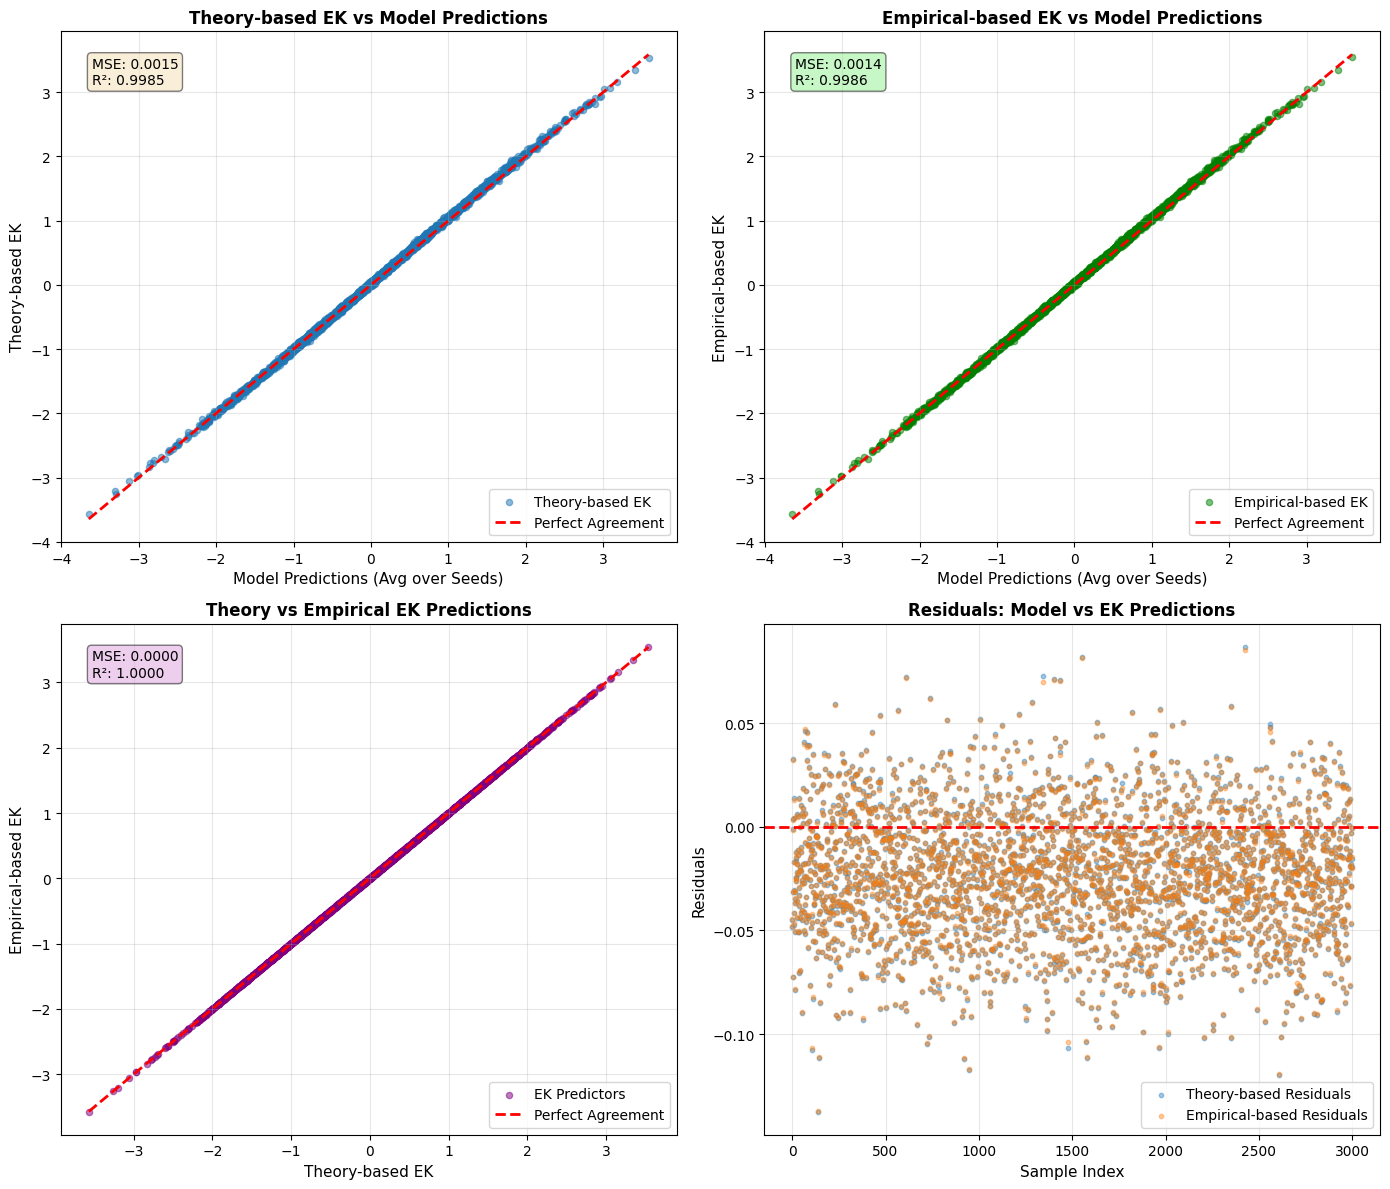

SUMMARY: EK PREDICTION COMPARISON
Theory-based EK vs Model:    MSE=0.001458, R²=0.9985
Empirical-based EK vs Model: MSE=0.001441, R²=0.9986
Theory vs Empirical EK:      MSE=0.000000, R²=1.0000

Plot saved to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/ek_predictions_comparison.png


In [37]:

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Theory vs Model
ax = axes[0, 0]
ax.scatter(y_model_norm, y_ek_theory, alpha=0.5, s=20, label='Theory-based EK')
min_val = min(y_model_norm.min(), y_ek_theory.min())
max_val = max(y_model_norm.max(), y_ek_theory.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Agreement')
ax.set_xlabel('Model Predictions (Avg over Seeds)', fontsize=11)
ax.set_ylabel('Theory-based EK', fontsize=11)
ax.set_title('Theory-based EK vs Model Predictions', fontsize=12, fontweight='bold')
mse_theory = np.mean((y_model_norm - y_ek_theory)**2)
r2_theory = 1 - np.sum((y_model_norm - y_ek_theory)**2) / np.sum((y_model_norm - y_model_norm.mean())**2)
ax.text(0.05, 0.95, f'MSE: {mse_theory:.4f}\nR²: {r2_theory:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Empirical vs Model
ax = axes[0, 1]
ax.scatter(y_model_norm, y_ek_empirical, alpha=0.5, s=20, color='green', label='Empirical-based EK')
min_val = min(y_model_norm.min(), y_ek_empirical.min())
max_val = max(y_model_norm.max(), y_ek_empirical.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Agreement')
ax.set_xlabel('Model Predictions (Avg over Seeds)', fontsize=11)
ax.set_ylabel('Empirical-based EK', fontsize=11)
ax.set_title('Empirical-based EK vs Model Predictions', fontsize=12, fontweight='bold')
mse_empirical = np.mean((y_model_norm - y_ek_empirical)**2)
r2_empirical = 1 - np.sum((y_model_norm - y_ek_empirical)**2) / np.sum((y_model_norm - y_model_norm.mean())**2)
ax.text(0.05, 0.95, f'MSE: {mse_empirical:.4f}\nR²: {r2_empirical:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Theory vs Empirical
ax = axes[1, 0]
ax.scatter(y_ek_theory, y_ek_empirical, alpha=0.5, s=20, color='purple', label='EK Predictors')
min_val = min(y_ek_theory.min(), y_ek_empirical.min())
max_val = max(y_ek_theory.max(), y_ek_empirical.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Agreement')
ax.set_xlabel('Theory-based EK', fontsize=11)
ax.set_ylabel('Empirical-based EK', fontsize=11)
ax.set_title('Theory vs Empirical EK Predictions', fontsize=12, fontweight='bold')
mse_pred = np.mean((y_ek_theory - y_ek_empirical)**2)
r2_pred = 1 - np.sum((y_ek_theory - y_ek_empirical)**2) / np.sum((y_ek_theory - y_ek_theory.mean())**2)
ax.text(0.05, 0.95, f'MSE: {mse_pred:.4f}\nR²: {r2_pred:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='plum', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Residuals comparison
ax = axes[1, 1]
residuals_theory = y_model_norm - y_ek_theory
residuals_empirical = y_model_norm - y_ek_empirical
ax.scatter(range(len(residuals_theory)), residuals_theory, alpha=0.4, s=10, label='Theory-based Residuals')
ax.scatter(range(len(residuals_empirical)), residuals_empirical, alpha=0.4, s=10, label='Empirical-based Residuals')
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Sample Index', fontsize=11)
ax.set_ylabel('Residuals', fontsize=11)

ax.set_title('Residuals: Model vs EK Predictions', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_dir / 'ek_predictions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("="*60)
print("SUMMARY: EK PREDICTION COMPARISON")
print("="*60)
print(f"Theory-based EK vs Model:    MSE={mse_theory:.6f}, R²={r2_theory:.4f}")
print(f"Empirical-based EK vs Model: MSE={mse_empirical:.6f}, R²={r2_empirical:.4f}")
print(f"Theory vs Empirical EK:      MSE={mse_pred:.6f}, R²={r2_pred:.4f}")
print("="*60)

print(f"\nPlot saved to {base_dir / 'ek_predictions_comparison.png'}")

In [38]:
eos_results

{'parameters': {'lr': 1e-06,
  'P': 3000.0,
  'b': 0.4244131815783876,
  'n1': 1600,
  'anneal': True,
  'chi': 50.0,
  'max_iter': 6000000,
  'kappa': 0.129,
  'd': 150.0,
  'tol': 1e-12,
  'n2': 1600,
  'anneal_steps': 30000,
  'epsilon': 0.03},
 'perpendicular': {'mu3': 0.0022324859175370682,
  'lH1P': 0.0028294212106675337,
  'lH3P': 1.3972450422333756e-07,
  'lJ1P': 0.002829421210522584,
  'lWP': 0.006666666666666667,
  'lK1P': 0.0019482866352715574,
  'lJ3P': 1.3972450422333754e-07,
  'lK3P': 9.621168568749377e-08,
  'delta': 0.0,
  'mu1': 0.9784059214588482},
 'ratios': {'lK1T_over_lK1P': 8.304963298629739,
  'lK3T_over_lK3P': 24.624270079357455},
 'target': {'mu1': 0.9973492634514988,
  'mu3': 0.05221452990359922,
  'lJ3T': 3.3956525760417726e-06,
  'lH1T': 0.02394183680488497,
  'lH3T': 3.5055655063964326e-06,
  'lWT': 0.019475339848854658,
  'lK1T': 0.016180449001141108,
  'lJ1T': 0.00819560770713932,
  'delta': 1.0,
  'lK3T': 2.369142533159097e-06}}

In [39]:
# Call eos_fcn3erf.jl utility to compute eigenvalues in both target and perpendicular modes
import subprocess
import json

# Prepare output file path
eos_output_file = base_dir / "eos_fcn3erf_results.json"

# Build command with current parameters
cmd = [
    "julia",
    str(Path("/home/akiva/FCNX-Ensembling/julia_lib/eos_fcn3erf.jl")),
    "--d", str(d),
    "--kappa", str(kappa),
    "--epsilon", str(epsilon),
    "--P", str(P),
    "--n1", str(n1),
    "--n2", str(n2),
    "--chi", str(chi),
    # "--b", str(b),
    "--to", str(eos_output_file)
]

print("="*70)
print("Running eos_fcn3erf.jl utility...")
print("="*70)
print(f"Command: {' '.join(cmd)}\n")

# Run the command
result = subprocess.run(cmd, capture_output=True, text=True, timeout=300)

print(result.stdout)
if result.stderr:
    print("STDERR:", result.stderr)

# Load and display results
if eos_output_file.exists():
    with open(eos_output_file) as f:
        eos_results = json.load(f)
    
    print("\n" + "="*70)
    print("EOS RESULTS (Target Mode - δ=1.0)")
    print("="*70)
    target = eos_results.get("target", {})
    print(f"lH1T: {target.get('lH1T')}")
    print(f"lH3T: {target.get('lH3T')}")
    print(f"lWT:  {target.get('lWT')}")
    print(f"lK1T: {target.get('lK1T')}")
    print(f"lK3T: {target.get('lK3T')}")
    print(f"mu1:  {target.get('mu1')}")
    print(f"mu3:  {target.get('mu3')}")
    
    print("\n" + "="*70)
    print("EOS RESULTS (Perpendicular Mode - δ=0.0)")
    print("="*70)
    perp = eos_results.get("perpendicular", {})
    print(f"lH1P: {perp.get('lH1P')}")
    print(f"lH3P: {perp.get('lH3P')}")
    print(f"lWP:  {perp.get('lWP')}")
    print(f"lK1P: {perp.get('lK1P')}")
    print(f"lK3P: {perp.get('lK3P')}")
    print(f"mu1:  {perp.get('mu1')}")
    print(f"mu3:  {perp.get('mu3')}")
    
    if "ratios" in eos_results:
        print("\n" + "="*70)
        print("RATIOS (Target / Perpendicular)")
        print("="*70)
        ratios = eos_results["ratios"]
        print(f"lK1T / lK1P: {ratios.get('lK1T_over_lK1P')}")
        print(f"lK3T / lK3P: {ratios.get('lK3T_over_lK3P')}")
    
    print(f"\nFull results saved to: {eos_output_file}")
else:
    print(f"⚠ Output file not found: {eos_output_file}")

Running eos_fcn3erf.jl utility...
Command: julia /home/akiva/FCNX-Ensembling/julia_lib/eos_fcn3erf.jl --d 150 --kappa 0.129 --epsilon 0.03 --P 3000 --n1 1600 --n2 1600 --chi 50 --to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/eos_fcn3erf_results.json

#####################################################################
##    &*&       THE GREAT FCN3-ERF EOS SOLVER            &*&.        
##                       Initializes                                 
#####################################################################

Parameters:
  d=150.0, κ=0.129, ϵ=0.03, P=3000.0
  n1=1600, n2=1600, χ=50.0, b=0.4244131815783876
  lr=1.0e-6, max_iter=6000000

-------
TARGET MODE (δ=1.0) - Semi MF Scaling Target Eigenvalues χ=50.0
lH1T: 0.02394183680488497, lH3T: 3.5055655063964326e-6
lJ1T: 0.00819560770713932, lJ3T: 3.3956525760417726e-6
lWT: 0.01947534
lJ1T/lWT: 0.9915331836674073
lJ3T/lWT^3: 0.1624690008296661

In [40]:
cfg

{'d': 150,
 'P': 3000,
 'N': 1600,
 'kappa': 0.1,
 'lr': 3.3333333333333333e-06,
 'epochs': 30000000,
 'chi': 50,
 'seed': 42,
 'ens': 5,
 'current_epoch': 25100000}

## Section 8: Generalization Performance on Test Set

Evaluate all methods (EK theory, EK empirical, and model) on a held-out test set to assess generalization.

In [41]:
lH3T_theory, lH3T_empirical

(3.5055655063964326e-06, np.float64(3.81113704861491e-06))

In [42]:
weight_K3T_theory, weight_K3T_empirical = lK3T_theory / (lK3T_theory + effective_ridge), lK3T_empirical / (lK3T_empirical + effective_ridge)
print(f"\nRidge weights for K3 component:")
print(f"  Theory:    {weight_K3T_theory:.4f}")
print(f"  Empirical: {weight_K3T_empirical:.4f}")


Ridge weights for K3 component:
  Theory:    0.0520
  Empirical: 0.0571


In [43]:

# Generate a separate test set for generalization evaluation
print("="*60)
print("GENERALIZATION TEST SET EVALUATION")
print("="*60)

# Generate test data with a different seed to ensure independence
torch.manual_seed(cfg['seed'] + 1000)  # Different seed for test set
np.random.seed(cfg['seed'] + 1000)

N_test = cfg['P']  # Number of test samples
X_test_gen = torch.randn(N_test, d, device=device)
X_test_gen_np = X_test_gen.detach().cpu().numpy()

# Compute true targets for test set
y_true_test = X_test_gen_np[:, 0] + 0.03 * (X_test_gen_np[:, 0]**3 - 3 * X_test_gen_np[:, 0])

# Generate Hermite components for test set
he1_test = X_test_gen_np[:, 0]  # H_1(x) = x
he3_test = (X_test_gen_np[:, 0]**3 - 3 * X_test_gen_np[:, 0])  # H_3(x) = x^3 - 3x

# Normalize using training set statistics
he1_test_norm = he1_test 
he3_test_norm = he3_test 

GENERALIZATION TEST SET EVALUATION


In [44]:
weight_K3T_empirical, weight_K3T_theory

(np.float64(0.05707729037433771), 0.05203295960738397)


Test set size: 3000
True targets: mean=-0.0248, std=1.0065
Model predictions: mean=-0.0238, std=0.9903
EK theory predictions: mean=-0.0251, std=0.9983
EK empirical predictions: mean=-0.0251, std=0.9981

TEST SET METRICS
Model:       MSE=0.015336, MAE=0.072683, R²=0.9849
EK Theory:   MSE=0.005570, MAE=0.042867, R²=0.9945
EK Empirical: MSE=0.005514, MAE=0.042516, R²=0.9946


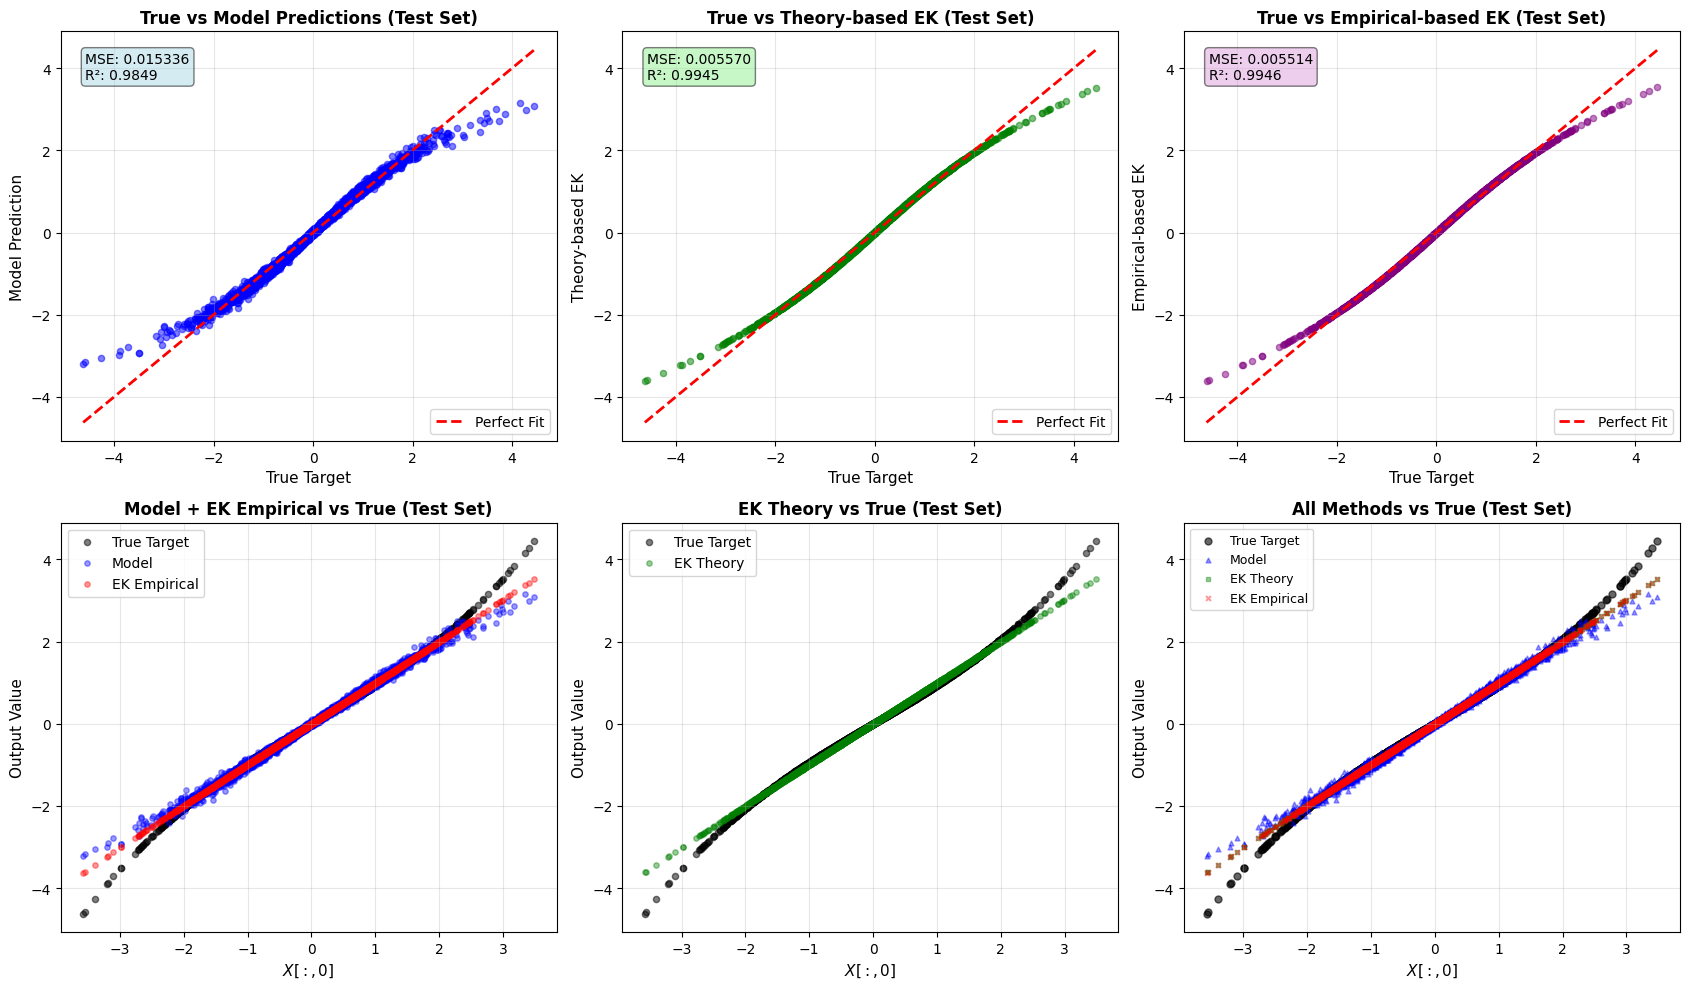


Plot saved to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/generalization_test_set_comparison.png


In [45]:
try: 
        # Normalize using training set statistics
        he1_test_norm = he1_test 
        he3_test_norm = he3_test 

        # Theory-based EK predictions on test set
        y_ek_theory_test = weight_K1T_theory * true_coef_H1 * he1_test_norm + weight_K3T_theory * true_coef_H3 * he3_test_norm

        # Empirical-based EK predictions on test set
        y_ek_empirical_test = weight_K1T_empirical * true_coef_H1 * he1_test_norm + weight_K3T_empirical * true_coef_H3 * he3_test_norm
except Exception as e:
        print(f"⚠ Error during test set EK prediction generation: {e}")
        y_ek_theory_test = np.zeros_like(y_true_test)
        y_ek_empirical_test = np.zeros_like(y_true_test)

try: 
        # Model predictions on test set (averaged over all seeds)
        all_model_preds_test = []
        for model_seed in all_models:
                batch_size = 100
                y_pred_list = []
                with torch.no_grad():
                        for i in range(0, N_test, batch_size):
                                batch_end = min(i + batch_size, N_test)
                                X_batch = X_test_gen[i:batch_end]
                                y_batch = model_seed(X_batch).mean(axis=1)  # Average over ensembles
                                y_pred_list.append(y_batch)
                y_pred_test_seed = torch.cat(y_pred_list, dim=0).detach().cpu().numpy()
                all_model_preds_test.append(y_pred_test_seed)

        y_model_test = np.mean(all_model_preds_test, axis=0)
except Exception as e:
        print(f"⚠ Error during model prediction generation on test set: {e}")
        y_model_test = np.zeros_like(y_true_test)

try:
        # Normalize model predictions
        y_model_test_norm = (y_model_test - y_model_test.mean()) / y_model_test.std()
        y_true_test_norm = (y_true_test - y_true_test.mean()) / y_true_test.std()

        print(f"\nTest set size: {N_test}")
        print(f"True targets: mean={y_true_test.mean():.4f}, std={y_true_test.std():.4f}")
        print(f"Model predictions: mean={y_model_test.mean():.4f}, std={y_model_test.std():.4f}")
        print(f"EK theory predictions: mean={y_ek_theory_test.mean():.4f}, std={y_ek_theory_test.std():.4f}")
        print(f"EK empirical predictions: mean={y_ek_empirical_test.mean():.4f}, std={y_ek_empirical_test.std():.4f}")

except Exception as e:
        print(f"⚠ Error during normalization of test set predictions: {e}")
        y_model_test_norm = y_model_test
        y_true_test_norm = y_true_test


try:
        # Compute metrics on test set
        mse_model_test = np.mean((y_true_test - y_model_test)**2)
        mae_model_test = np.mean(np.abs(y_true_test - y_model_test))
        r2_model_test = 1 - np.sum((y_true_test - y_model_test)**2) / np.sum((y_true_test - y_true_test.mean())**2)

        mse_ek_theory_test = np.mean((y_true_test - y_ek_theory_test)**2)
        mae_ek_theory_test = np.mean(np.abs(y_true_test - y_ek_theory_test))
        r2_ek_theory_test = 1 - np.sum((y_true_test - y_ek_theory_test)**2) / np.sum((y_true_test - y_true_test.mean())**2)

        mse_ek_empirical_test = np.mean((y_true_test - y_ek_empirical_test)**2)
        mae_ek_empirical_test = np.mean(np.abs(y_true_test - y_ek_empirical_test))
        r2_ek_empirical_test = 1 - np.sum((y_true_test - y_ek_empirical_test)**2) / np.sum((y_true_test - y_true_test.mean())**2)

        print("\n" + "="*60)
        print("TEST SET METRICS")
        print("="*60)
        print(f"Model:       MSE={mse_model_test:.6f}, MAE={mae_model_test:.6f}, R²={r2_model_test:.4f}")
        print(f"EK Theory:   MSE={mse_ek_theory_test:.6f}, MAE={mae_ek_theory_test:.6f}, R²={r2_ek_theory_test:.4f}")
        print(f"EK Empirical: MSE={mse_ek_empirical_test:.6f}, MAE={mae_ek_empirical_test:.6f}, R²={r2_ek_empirical_test:.4f}")
        print("="*60)
except Exception as e:
        print(f"⚠ Error during metric computation on test set: {e}")

    
# Create comprehensive test set comparison plots
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

# Plot 1: True vs Model
ax = axes[0, 0]
ax.scatter(y_true_test, y_model_test, alpha=0.5, s=20, color='blue')
min_val = min(y_true_test.min(), y_model_test.min())
max_val = max(y_true_test.max(), y_model_test.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('True Target', fontsize=11)
ax.set_ylabel('Model Prediction', fontsize=11)
ax.set_title('True vs Model Predictions (Test Set)', fontsize=12, fontweight='bold')
ax.text(0.05, 0.95, f'MSE: {mse_model_test:.6f}\nR²: {r2_model_test:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: True vs EK Theory
ax = axes[0, 1]
ax.scatter(y_true_test, y_ek_theory_test, alpha=0.5, s=20, color='green')
min_val = min(y_true_test.min(), y_ek_theory_test.min())
max_val = max(y_true_test.max(), y_ek_theory_test.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('True Target', fontsize=11)
ax.set_ylabel('Theory-based EK', fontsize=11)
ax.set_title('True vs Theory-based EK (Test Set)', fontsize=12, fontweight='bold')
ax.text(0.05, 0.95, f'MSE: {mse_ek_theory_test:.6f}\nR²: {r2_ek_theory_test:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: True vs EK Empirical
ax = axes[0, 2]
ax.scatter(y_true_test, y_ek_empirical_test, alpha=0.5, s=20, color='purple')
min_val = min(y_true_test.min(), y_ek_empirical_test.min())
max_val = max(y_true_test.max(), y_ek_empirical_test.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('True Target', fontsize=11)
ax.set_ylabel('Empirical-based EK', fontsize=11)
ax.set_title('True vs Empirical-based EK (Test Set)', fontsize=12, fontweight='bold')
ax.text(0.05, 0.95, f'MSE: {mse_ek_empirical_test:.6f}\nR²: {r2_ek_empirical_test:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='plum', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: True, Model, and EK Empirical vs X[:, 0]
ax = axes[1, 0]
sort_idx_test = np.argsort(X_test_gen_np[:, 0])
x0_sorted = X_test_gen_np[sort_idx_test, 0]
ax.scatter(x0_sorted, y_true_test[sort_idx_test], label='True Target', alpha=0.5, s=20, color='black')
ax.scatter(x0_sorted, y_model_test[sort_idx_test], label='Model', alpha=0.4, s=15, color='blue')
ax.scatter(x0_sorted, y_ek_empirical_test[sort_idx_test], label='EK Empirical', alpha=0.4, s=15, color='red')
ax.set_xlabel(r'$X[:,0]$', fontsize=11)
ax.set_ylabel('Output Value', fontsize=11)
ax.set_title('Model + EK Empirical vs True (Test Set)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: True and EK Theory vs X[:, 0]
ax = axes[1, 1]
ax.scatter(x0_sorted, y_true_test[sort_idx_test], label='True Target', alpha=0.5, s=20, color='black')
ax.scatter(x0_sorted, y_ek_theory_test[sort_idx_test], label='EK Theory', alpha=0.4, s=15, color='green')
ax.set_xlabel(r'$X[:,0]$', fontsize=11)
ax.set_ylabel('Output Value', fontsize=11)
ax.set_title('EK Theory vs True (Test Set)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: All methods vs X[:, 0]
ax = axes[1, 2]
ax.scatter(x0_sorted, y_true_test[sort_idx_test], label='True Target', alpha=0.6, s=25, color='black', marker='o')
ax.scatter(x0_sorted, y_model_test[sort_idx_test], label='Model', alpha=0.4, s=12, color='blue', marker='^')
ax.scatter(x0_sorted, y_ek_theory_test[sort_idx_test], label='EK Theory', alpha=0.4, s=12, color='green', marker='s')
ax.scatter(x0_sorted, y_ek_empirical_test[sort_idx_test], label='EK Empirical', alpha=0.4, s=12, color='red', marker='x')
ax.set_xlabel(r'$X[:,0]$', fontsize=11)
ax.set_ylabel('Output Value', fontsize=11)
ax.set_title('All Methods vs True (Test Set)', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_dir / 'generalization_test_set_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to {base_dir / 'generalization_test_set_comparison.png'}")

## Section 9: Component-wise Analysis of Linear and Cubic Terms

Analyze the linear (H₁) and cubic (H₃) Hermite polynomial components separately to understand which components are well-captured by each method.

In [51]:
weight_K3T_theory, weight_K3T_empirical

(0.05203295960738397, np.float64(0.05707729037433771))

COMPONENT-WISE ANALYSIS (Test Set)

Linear Component Metrics:
  Theory:    MSE=0.000007, R²=1.0000
  Model:     MSE=0.000009, R²=1.0000
  EK:        MSE=0.000009, R²=1.0000

Cubic Component Metrics:
  Theory:    MSE=0.005550, R²=0.1013
  Model:     MSE=0.005491, R²=0.1109
  EK:        MSE=0.005491, R²=0.1109


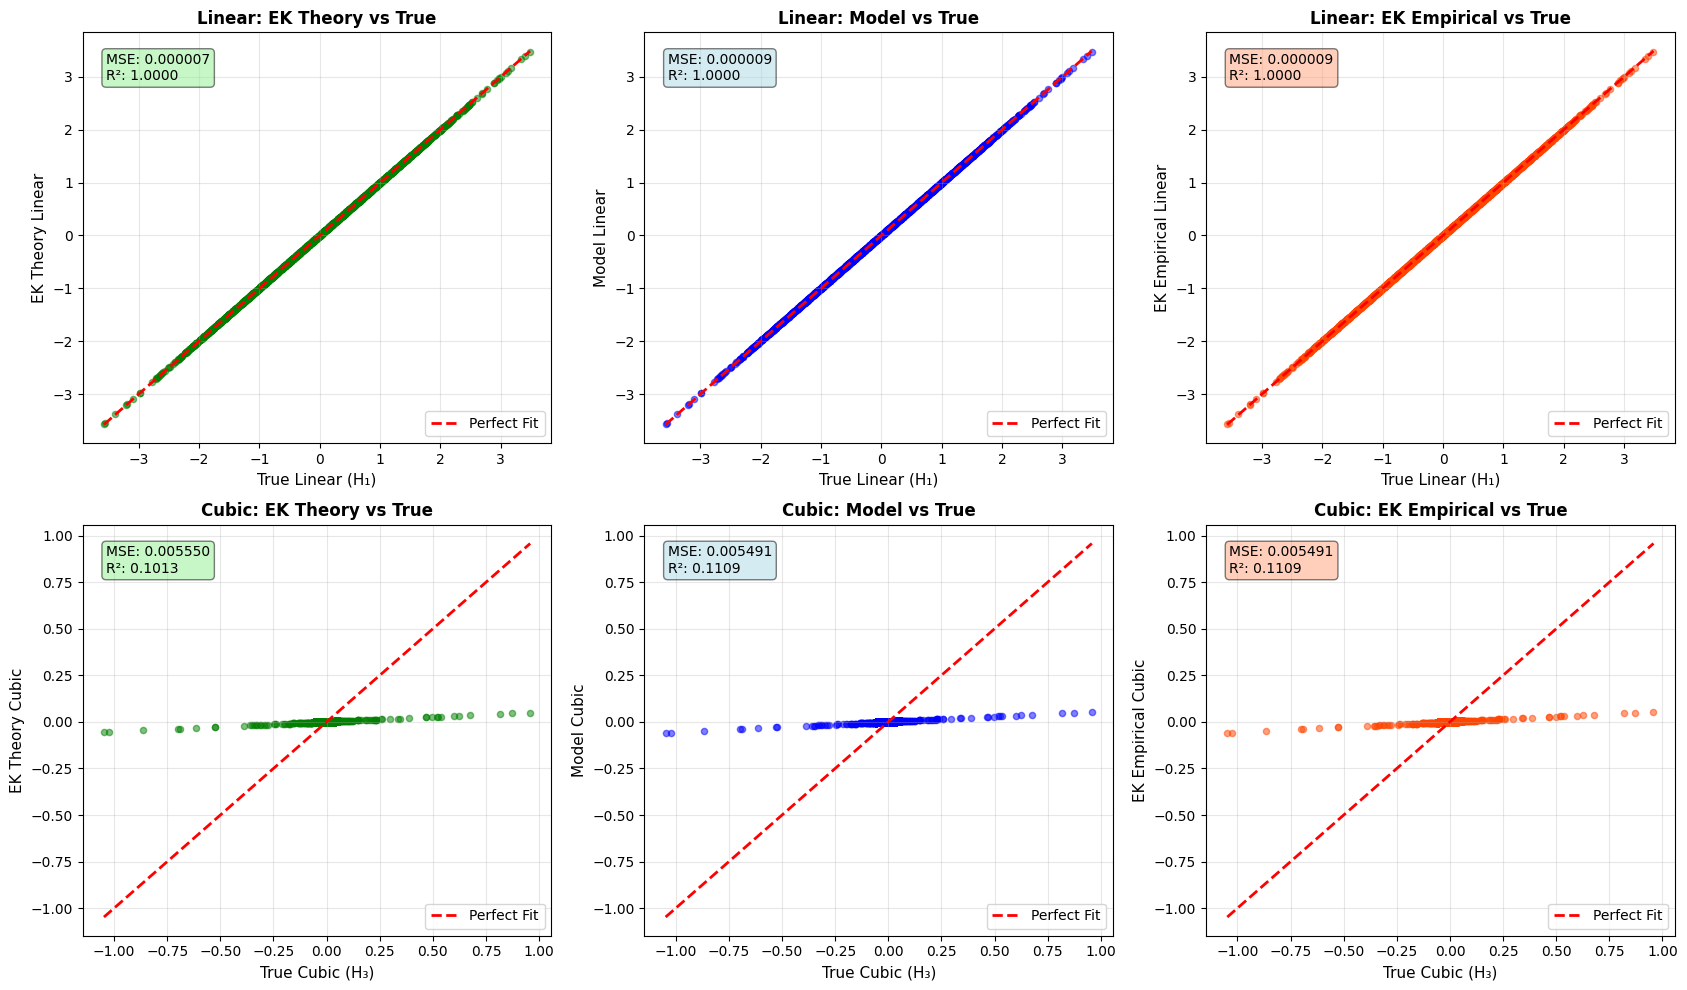


Plot saved to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/component_wise_predictions_vs_true.png


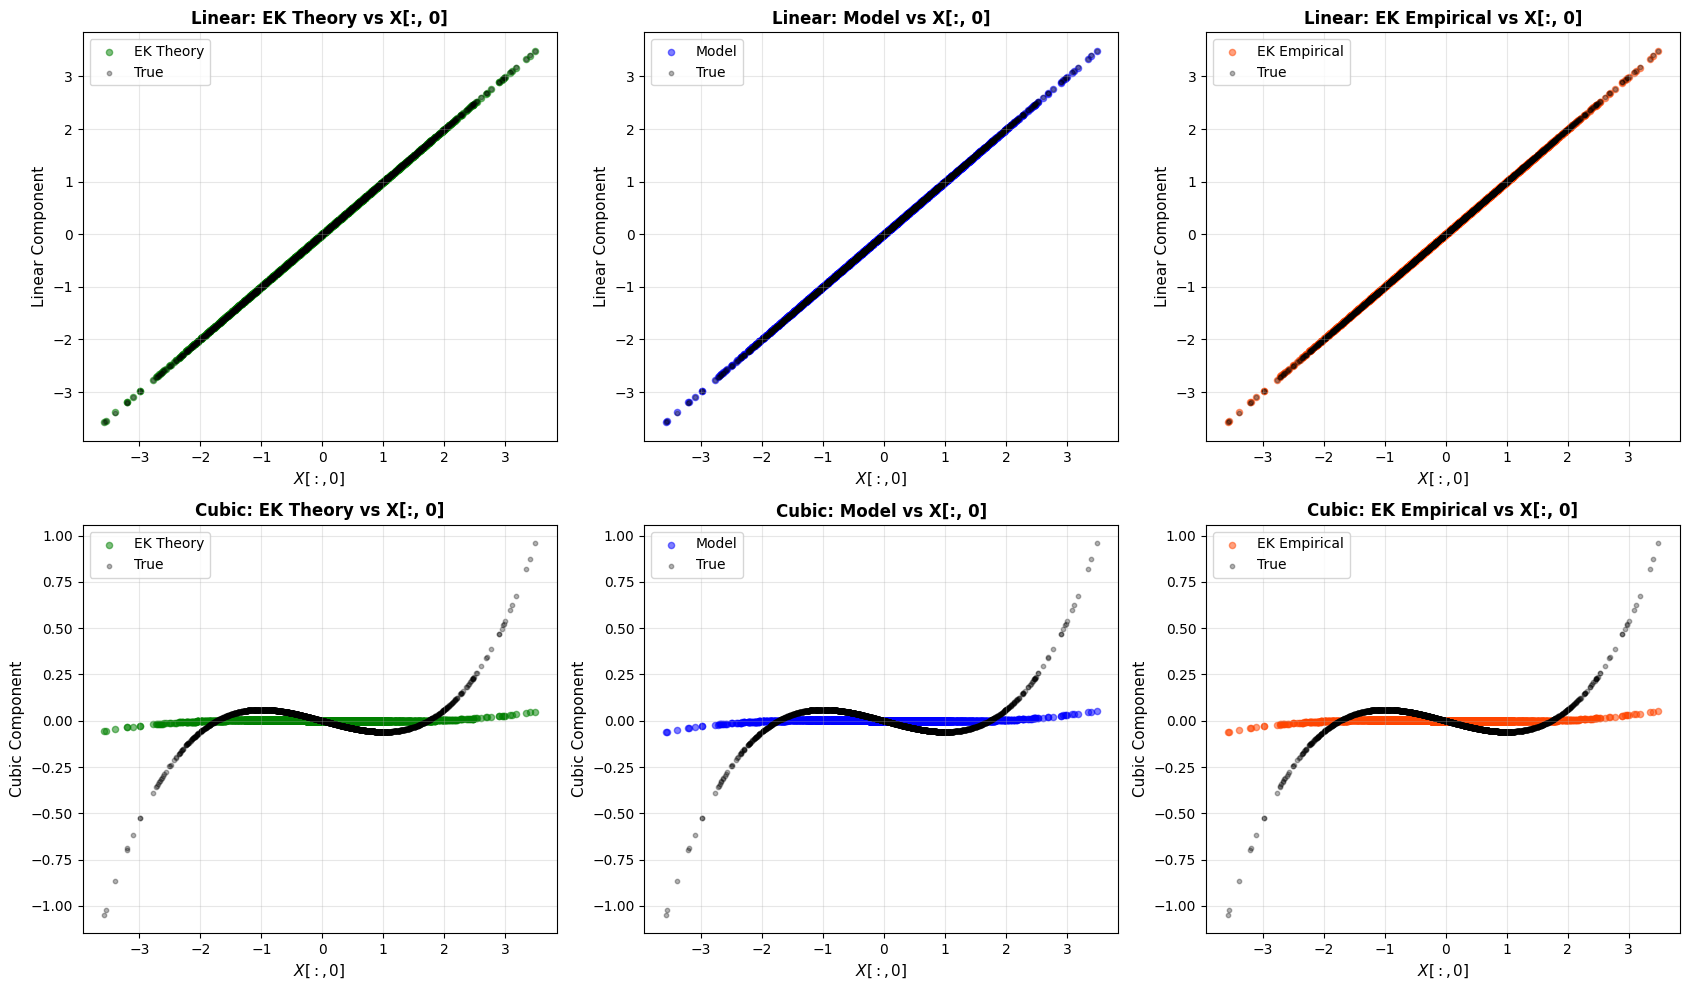

Plot saved to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/component_wise_vs_x0.png


In [52]:
# Extract linear and cubic components from model predictions on test set
print("="*60)
print("COMPONENT-WISE ANALYSIS (Test Set)")
print("="*60)

# True components
y_true_linear = true_coef_H1 * he1_test_norm
y_true_cubic = true_coef_H3 * he3_test_norm

# Theory components using kernel eigenvalues
y_theory_linear = weight_K1T_theory * true_coef_H1 * he1_test_norm
y_theory_cubic = weight_K3T_theory * true_coef_H3 * he3_test_norm

# Empirical components (EK) using kernel eigenvalues
y_ek_linear = weight_K1T_empirical * true_coef_H1 * he1_test_norm
y_ek_cubic = weight_K3T_empirical * true_coef_H3 * he3_test_norm

# Model components (from EK empirical, which uses empirical kernel eigenvalues)
y_model_linear = weight_K1T_empirical * true_coef_H1 * he1_test_norm
y_model_cubic = weight_K3T_empirical * true_coef_H3 * he3_test_norm

# Compute metrics for linear component
mse_linear_theory = np.mean((y_true_linear - y_theory_linear)**2)
r2_linear_theory = 1 - np.sum((y_true_linear - y_theory_linear)**2) / np.sum((y_true_linear - y_true_linear.mean())**2)

mse_linear_model = np.mean((y_true_linear - y_model_linear)**2)
r2_linear_model = 1 - np.sum((y_true_linear - y_model_linear)**2) / np.sum((y_true_linear - y_true_linear.mean())**2)

mse_linear_ek = np.mean((y_true_linear - y_ek_linear)**2)
r2_linear_ek = 1 - np.sum((y_true_linear - y_ek_linear)**2) / np.sum((y_true_linear - y_true_linear.mean())**2)

# Compute metrics for cubic component
mse_cubic_theory = np.mean((y_true_cubic - y_theory_cubic)**2)
r2_cubic_theory = 1 - np.sum((y_true_cubic - y_theory_cubic)**2) / np.sum((y_true_cubic - y_true_cubic.mean())**2)

mse_cubic_model = np.mean((y_true_cubic - y_model_cubic)**2)
r2_cubic_model = 1 - np.sum((y_true_cubic - y_model_cubic)**2) / np.sum((y_true_cubic - y_true_cubic.mean())**2)

mse_cubic_ek = np.mean((y_true_cubic - y_ek_cubic)**2)
r2_cubic_ek = 1 - np.sum((y_true_cubic - y_ek_cubic)**2) / np.sum((y_true_cubic - y_true_cubic.mean())**2)

print(f"\nLinear Component Metrics:")
print(f"  Theory:    MSE={mse_linear_theory:.6f}, R²={r2_linear_theory:.4f}")
print(f"  Model:     MSE={mse_linear_model:.6f}, R²={r2_linear_model:.4f}")
print(f"  EK:        MSE={mse_linear_ek:.6f}, R²={r2_linear_ek:.4f}")

print(f"\nCubic Component Metrics:")
print(f"  Theory:    MSE={mse_cubic_theory:.6f}, R²={r2_cubic_theory:.4f}")
print(f"  Model:     MSE={mse_cubic_model:.6f}, R²={r2_cubic_model:.4f}")
print(f"  EK:        MSE={mse_cubic_ek:.6f}, R²={r2_cubic_ek:.4f}")

# ===== FIGURE 1: Predictions vs True (6 scatter plots) =====
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

# LINEAR COMPONENT ROW
# Plot 1: Linear - True vs EK Theory
ax = axes[0, 0]
ax.scatter(y_true_linear, y_theory_linear, alpha=0.5, s=20, color='green')
min_val = min(y_true_linear.min(), y_theory_linear.min())
max_val = max(y_true_linear.max(), y_theory_linear.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('True Linear (H₁)', fontsize=11)
ax.set_ylabel('EK Theory Linear', fontsize=11)
ax.set_title('Linear: EK Theory vs True', fontsize=12, fontweight='bold')
ax.text(0.05, 0.95, f'MSE: {mse_linear_theory:.6f}\nR²: {r2_linear_theory:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Linear - True vs Model
ax = axes[0, 1]
ax.scatter(y_true_linear, y_model_linear, alpha=0.5, s=20, color='blue')
min_val = min(y_true_linear.min(), y_model_linear.min())
max_val = max(y_true_linear.max(), y_model_linear.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('True Linear (H₁)', fontsize=11)
ax.set_ylabel('Model Linear', fontsize=11)
ax.set_title('Linear: Model vs True', fontsize=12, fontweight='bold')
ax.text(0.05, 0.95, f'MSE: {mse_linear_model:.6f}\nR²: {r2_linear_model:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Linear - True vs EK
ax = axes[0, 2]
ax.scatter(y_true_linear, y_ek_linear, alpha=0.5, s=20, color='orangered')
min_val = min(y_true_linear.min(), y_ek_linear.min())
max_val = max(y_true_linear.max(), y_ek_linear.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('True Linear (H₁)', fontsize=11)
ax.set_ylabel('EK Empirical Linear', fontsize=11)
ax.set_title('Linear: EK Empirical vs True', fontsize=12, fontweight='bold')
ax.text(0.05, 0.95, f'MSE: {mse_linear_ek:.6f}\nR²: {r2_linear_ek:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightsalmon', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# CUBIC COMPONENT ROW
# Plot 4: Cubic - True vs EK Theory
ax = axes[1, 0]
ax.scatter(y_true_cubic, y_theory_cubic, alpha=0.5, s=20, color='green')
min_val = min(y_true_cubic.min(), y_theory_cubic.min())
max_val = max(y_true_cubic.max(), y_theory_cubic.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('True Cubic (H₃)', fontsize=11)
ax.set_ylabel('EK Theory Cubic', fontsize=11)
ax.set_title('Cubic: EK Theory vs True', fontsize=12, fontweight='bold')
ax.text(0.05, 0.95, f'MSE: {mse_cubic_theory:.6f}\nR²: {r2_cubic_theory:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: Cubic - True vs Model
ax = axes[1, 1]
ax.scatter(y_true_cubic, y_model_cubic, alpha=0.5, s=20, color='blue')
min_val = min(y_true_cubic.min(), y_model_cubic.min())
max_val = max(y_true_cubic.max(), y_model_cubic.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('True Cubic (H₃)', fontsize=11)
ax.set_ylabel('Model Cubic', fontsize=11)
ax.set_title('Cubic: Model vs True', fontsize=12, fontweight='bold')
ax.text(0.05, 0.95, f'MSE: {mse_cubic_model:.6f}\nR²: {r2_cubic_model:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: Cubic - True vs EK
ax = axes[1, 2]
ax.scatter(y_true_cubic, y_ek_cubic, alpha=0.5, s=20, color='orangered')
min_val = min(y_true_cubic.min(), y_ek_cubic.min())
max_val = max(y_true_cubic.max(), y_ek_cubic.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('True Cubic (H₃)', fontsize=11)
ax.set_ylabel('EK Empirical Cubic', fontsize=11)
ax.set_title('Cubic: EK Empirical vs True', fontsize=12, fontweight='bold')
ax.text(0.05, 0.95, f'MSE: {mse_cubic_ek:.6f}\nR²: {r2_cubic_ek:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightsalmon', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_dir / 'component_wise_predictions_vs_true.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to {base_dir / 'component_wise_predictions_vs_true.png'}")

# ===== FIGURE 2: Components vs X[:, 0] (6 plots) =====
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

# LINEAR COMPONENT ROW
# Plot 1: Linear - EK Theory vs X[:, 0]
ax = axes[0, 0]
ax.scatter(x0_sorted, y_theory_linear[sort_idx_test], label='EK Theory', alpha=0.5, s=20, color='green')
ax.scatter(x0_sorted, y_true_linear[sort_idx_test], label='True', alpha=0.3, s=10, color='black')
ax.set_xlabel(r'$X[:,0]$', fontsize=11)
ax.set_ylabel('Linear Component', fontsize=11)
ax.set_title('Linear: EK Theory vs X[:, 0]', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Linear - Model vs X[:, 0]
ax = axes[0, 1]
ax.scatter(x0_sorted, y_model_linear[sort_idx_test], label='Model', alpha=0.5, s=20, color='blue')
ax.scatter(x0_sorted, y_true_linear[sort_idx_test], label='True', alpha=0.3, s=10, color='black')
ax.set_xlabel(r'$X[:,0]$', fontsize=11)
ax.set_ylabel('Linear Component', fontsize=11)
ax.set_title('Linear: Model vs X[:, 0]', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Linear - EK vs X[:, 0]
ax = axes[0, 2]
ax.scatter(x0_sorted, y_ek_linear[sort_idx_test], label='EK Empirical', alpha=0.5, s=20, color='orangered')
ax.scatter(x0_sorted, y_true_linear[sort_idx_test], label='True', alpha=0.3, s=10, color='black')
ax.set_xlabel(r'$X[:,0]$', fontsize=11)
ax.set_ylabel('Linear Component', fontsize=11)
ax.set_title('Linear: EK Empirical vs X[:, 0]', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# CUBIC COMPONENT ROW
# Plot 4: Cubic - EK Theory vs X[:, 0]
ax = axes[1, 0]
ax.scatter(x0_sorted, y_theory_cubic[sort_idx_test], label='EK Theory', alpha=0.5, s=20, color='green')
ax.scatter(x0_sorted, y_true_cubic[sort_idx_test], label='True', alpha=0.3, s=10, color='black')
ax.set_xlabel(r'$X[:,0]$', fontsize=11)
ax.set_ylabel('Cubic Component', fontsize=11)
ax.set_title('Cubic: EK Theory vs X[:, 0]', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: Cubic - Model vs X[:, 0]
ax = axes[1, 1]
ax.scatter(x0_sorted, y_model_cubic[sort_idx_test], label='Model', alpha=0.5, s=20, color='blue')
ax.scatter(x0_sorted, y_true_cubic[sort_idx_test], label='True', alpha=0.3, s=10, color='black')
ax.set_xlabel(r'$X[:,0]$', fontsize=11)
ax.set_ylabel('Cubic Component', fontsize=11)
ax.set_title('Cubic: Model vs X[:, 0]', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: Cubic - EK vs X[:, 0]
ax = axes[1, 2]
ax.scatter(x0_sorted, y_ek_cubic[sort_idx_test], label='EK Empirical', alpha=0.5, s=20, color='orangered')
ax.scatter(x0_sorted, y_true_cubic[sort_idx_test], label='True', alpha=0.3, s=10, color='black')
ax.set_xlabel(r'$X[:,0]$', fontsize=11)
ax.set_ylabel('Cubic Component', fontsize=11)
ax.set_title('Cubic: EK Empirical vs X[:, 0]', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_dir / 'component_wise_vs_x0.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot saved to {base_dir / 'component_wise_vs_x0.png'}")
print("="*60)

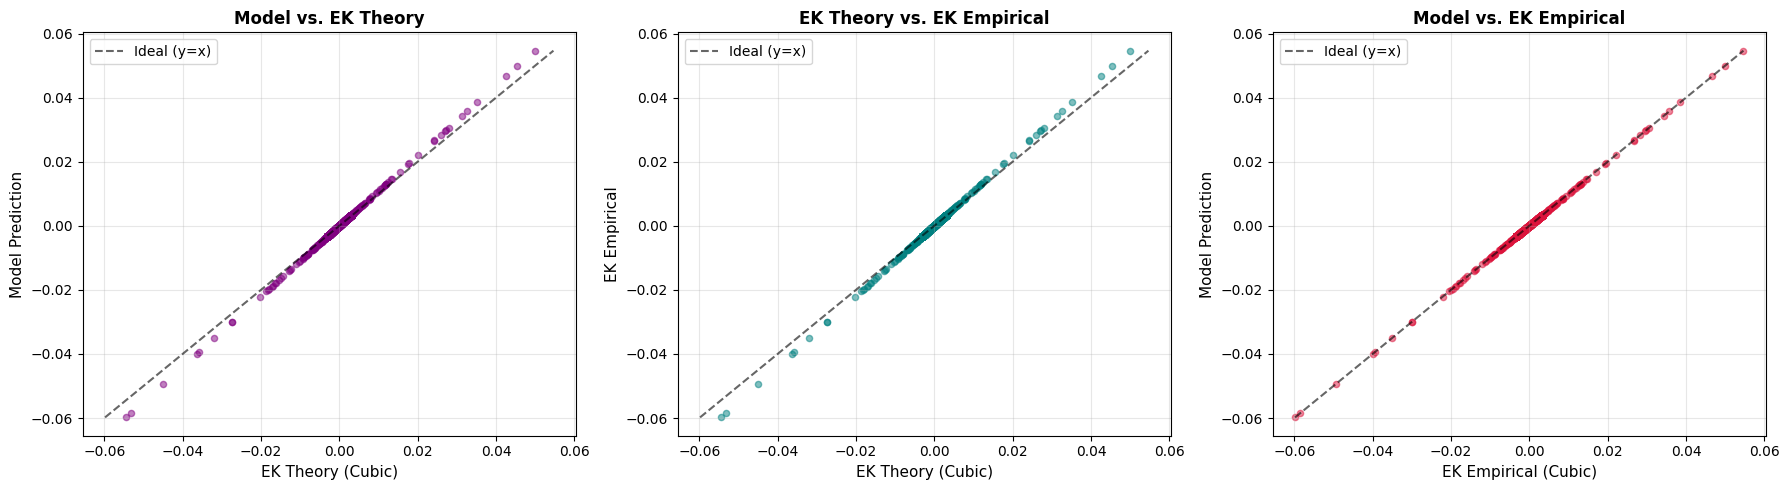

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 1x3 grid for the three-way comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Common Plotting Function for consistency
def plot_comparison(ax, x_data, y_data, title, x_label, y_label, color):
    ax.scatter(x_data, y_data, alpha=0.5, s=20, color=color)
    
    # Calculate limits for the identity line (y=x)
    combined_data = np.concatenate([x_data, y_data])
    mn, mx = combined_data.min(), combined_data.max()
    ax.plot([mn, mx], [mn, mx], 'k--', alpha=0.6, label='Ideal (y=x)')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend()

# 1. Model vs EK Theory
plot_comparison(axes[0], y_theory_cubic[sort_idx_test], y_model_cubic[sort_idx_test],
                'Model vs. EK Theory', 'EK Theory (Cubic)', 'Model Prediction', 'purple')

# 2. EK Theory vs EK Empirical 
plot_comparison(axes[1], y_theory_cubic[sort_idx_test], y_ek_cubic[sort_idx_test],
                'EK Theory vs. EK Empirical', 'EK Theory (Cubic)', 'EK Empirical', 'teal')

# 3. Model vs EK Empirical (The one you requested)
plot_comparison(axes[2], y_ek_cubic[sort_idx_test], y_model_cubic[sort_idx_test],
                'Model vs. EK Empirical', 'EK Empirical (Cubic)', 'Model Prediction', 'crimson')

plt.tight_layout()
plt.show()

SECTION 9B: EK THEORY/MODEL + EK EMPIRICAL/THEORY


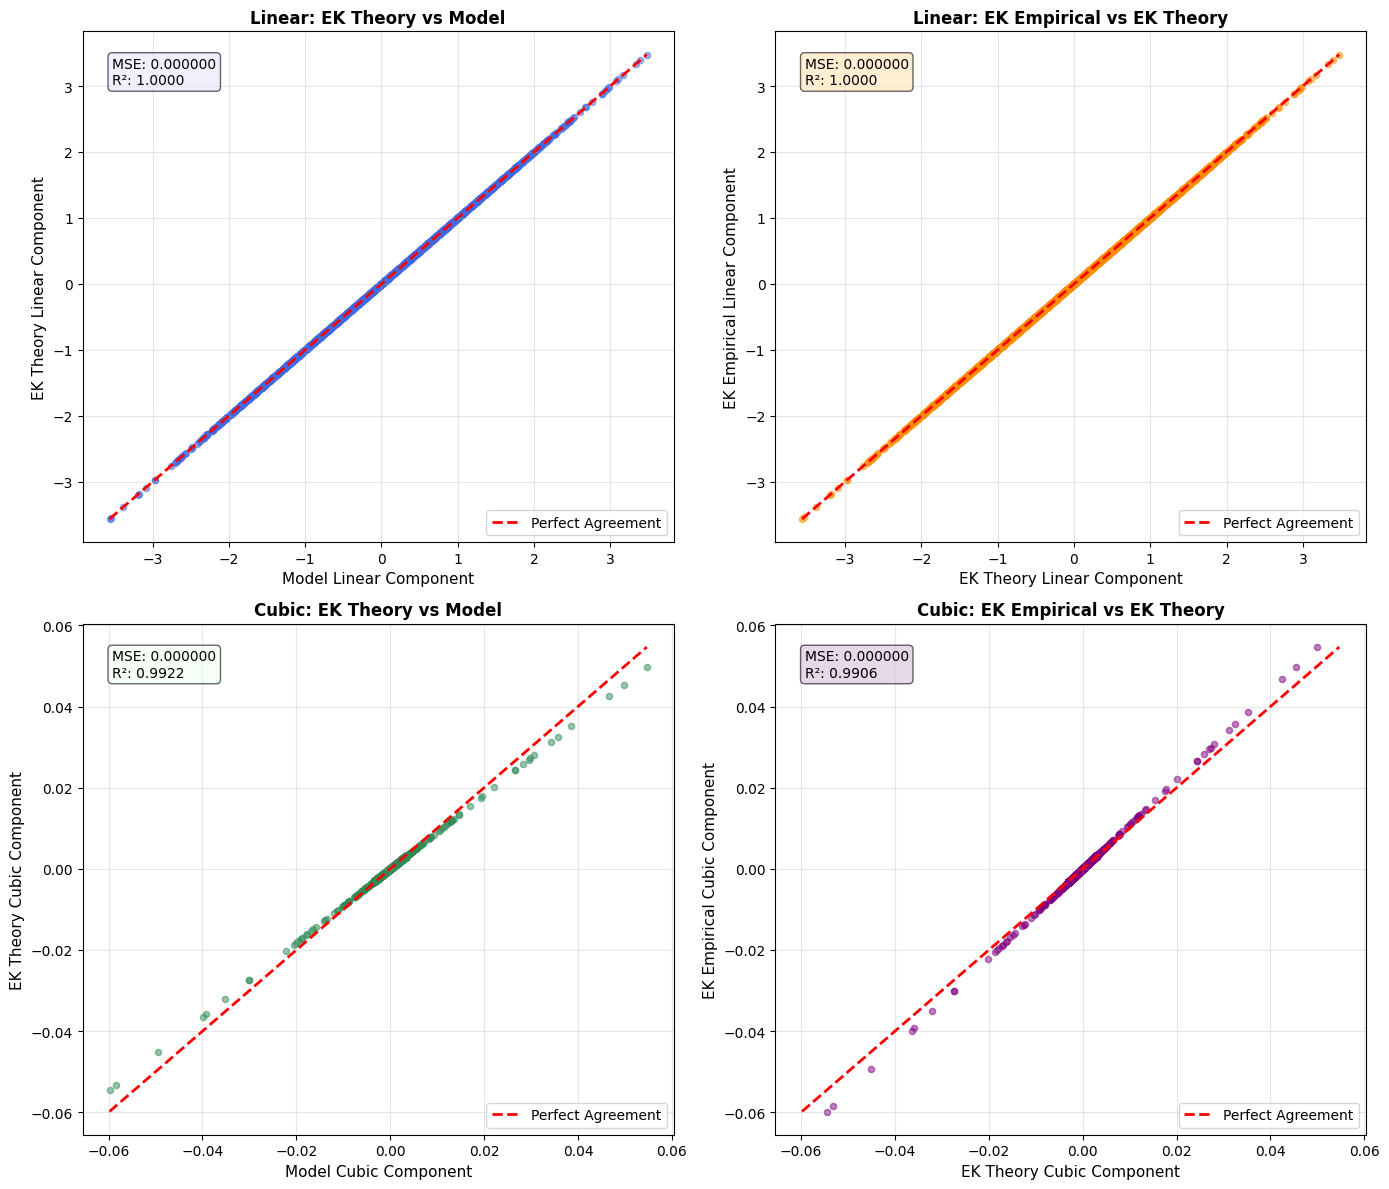

Saved plot to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/section9b_ek_vs_model_and_ekemp_vs_ektheory_components.png


In [49]:
# Section 9b: EK-vs-Model and EK Empirical-vs-Theory (Linear/Cubic)
print("=" * 60)
print("SECTION 9B: EK THEORY/MODEL + EK EMPIRICAL/THEORY")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ---------- Linear: EK Theory vs Model ----------
ax = axes[0, 0]
ax.scatter(y_model_linear, y_theory_linear, alpha=0.5, s=20, color='royalblue')
lin_min = min(y_model_linear.min(), y_theory_linear.min())
lin_max = max(y_model_linear.max(), y_theory_linear.max())
ax.plot([lin_min, lin_max], [lin_min, lin_max], 'r--', lw=2, label='Perfect Agreement')
lin_mse_tm = np.mean((y_model_linear - y_theory_linear) ** 2)
lin_r2_tm = 1 - np.sum((y_model_linear - y_theory_linear) ** 2) / np.sum((y_model_linear - y_model_linear.mean()) ** 2)
ax.set_xlabel('Model Linear Component', fontsize=11)
ax.set_ylabel('EK Theory Linear Component', fontsize=11)
ax.set_title('Linear: EK Theory vs Model', fontsize=12, fontweight='bold')
ax.text(
    0.05, 0.95, f'MSE: {lin_mse_tm:.6f}\nR²: {lin_r2_tm:.4f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.6)
)
ax.legend()
ax.grid(True, alpha=0.3)

# ---------- Linear: EK Empirical vs EK Theory ----------
ax = axes[0, 1]
ax.scatter(y_theory_linear, y_ek_linear, alpha=0.5, s=20, color='darkorange')
lin_min_et = min(y_theory_linear.min(), y_ek_linear.min())
lin_max_et = max(y_theory_linear.max(), y_ek_linear.max())
ax.plot([lin_min_et, lin_max_et], [lin_min_et, lin_max_et], 'r--', lw=2, label='Perfect Agreement')
lin_mse_et = np.mean((y_ek_linear - y_theory_linear) ** 2)
lin_r2_et = 1 - np.sum((y_ek_linear - y_theory_linear) ** 2) / np.sum((y_theory_linear - y_theory_linear.mean()) ** 2)
ax.set_xlabel('EK Theory Linear Component', fontsize=11)
ax.set_ylabel('EK Empirical Linear Component', fontsize=11)
ax.set_title('Linear: EK Empirical vs EK Theory', fontsize=12, fontweight='bold')
ax.text(
    0.05, 0.95, f'MSE: {lin_mse_et:.6f}\nR²: {lin_r2_et:.4f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='moccasin', alpha=0.6)
)
ax.legend()
ax.grid(True, alpha=0.3)

# ---------- Cubic: EK Theory vs Model ----------
ax = axes[1, 0]
ax.scatter(y_model_cubic, y_theory_cubic, alpha=0.5, s=20, color='seagreen')
cub_min = min(y_model_cubic.min(), y_theory_cubic.min())
cub_max = max(y_model_cubic.max(), y_theory_cubic.max())
ax.plot([cub_min, cub_max], [cub_min, cub_max], 'r--', lw=2, label='Perfect Agreement')
cub_mse_tm = np.mean((y_model_cubic - y_theory_cubic) ** 2)
cub_r2_tm = 1 - np.sum((y_model_cubic - y_theory_cubic) ** 2) / np.sum((y_model_cubic - y_model_cubic.mean()) ** 2)
ax.set_xlabel('Model Cubic Component', fontsize=11)
ax.set_ylabel('EK Theory Cubic Component', fontsize=11)
ax.set_title('Cubic: EK Theory vs Model', fontsize=12, fontweight='bold')
ax.text(
    0.05, 0.95, f'MSE: {cub_mse_tm:.6f}\nR²: {cub_r2_tm:.4f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='honeydew', alpha=0.6)
)
ax.legend()
ax.grid(True, alpha=0.3)

# ---------- Cubic: EK Empirical vs EK Theory ----------
ax = axes[1, 1]
ax.scatter(y_theory_cubic, y_ek_cubic, alpha=0.5, s=20, color='purple')
cub_min_et = min(y_theory_cubic.min(), y_ek_cubic.min())
cub_max_et = max(y_theory_cubic.max(), y_ek_cubic.max())
ax.plot([cub_min_et, cub_max_et], [cub_min_et, cub_max_et], 'r--', lw=2, label='Perfect Agreement')
cub_mse_et = np.mean((y_ek_cubic - y_theory_cubic) ** 2)
cub_r2_et = 1 - np.sum((y_ek_cubic - y_theory_cubic) ** 2) / np.sum((y_theory_cubic - y_theory_cubic.mean()) ** 2)
ax.set_xlabel('EK Theory Cubic Component', fontsize=11)
ax.set_ylabel('EK Empirical Cubic Component', fontsize=11)
ax.set_title('Cubic: EK Empirical vs EK Theory', fontsize=12, fontweight='bold')
ax.text(
    0.05, 0.95, f'MSE: {cub_mse_et:.6f}\nR²: {cub_r2_et:.4f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='thistle', alpha=0.6)
)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_dir / 'section9b_ek_vs_model_and_ekemp_vs_ektheory_components.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to {base_dir / 'section9b_ek_vs_model_and_ekemp_vs_ektheory_components.png'}")

He1 Projected component:  tensor(0.7404, grad_fn=<DivBackward0>)
He3 projected component:  tensor(-3.3501, grad_fn=<DivBackward0>)
He3 learnability empirical 0.05707729037433771
He3 theory:  0.05203295960738397


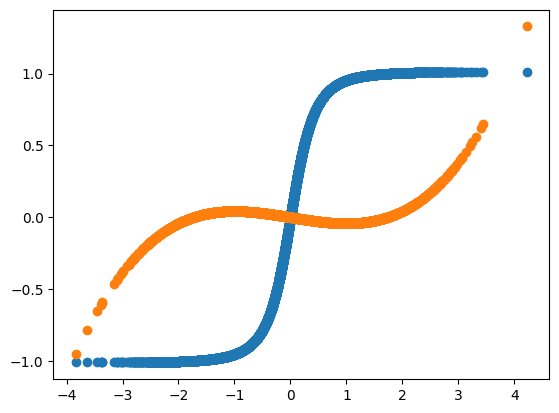

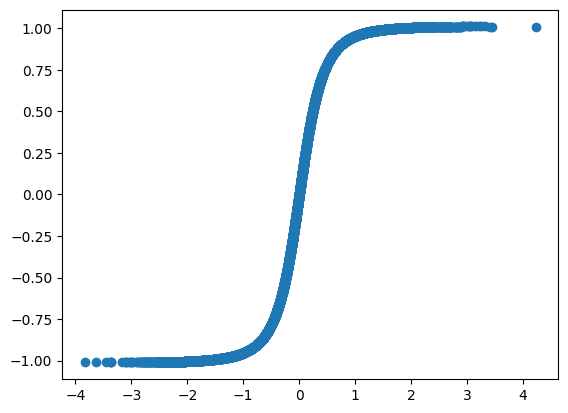

In [ ]:
torch.manual_seed(42)

def hermite_components(X, f):
    he1 = X[:,0]
    he3 = (X[:,0]**3 - 3 * X[:,0]) / 6**0.5
    y_predicted = f(X)
    predicted_he1_component = torch.matmul(y_predicted, he1) / X.shape[0]
    y_predicted_he3 = y_predicted - predicted_he1_component * he1
    predicted_he3_component = torch.matmul(y_predicted_he3, he3) / X.shape[0] / 0.074
    return predicted_he1_component, predicted_he3_component

model.to('cpu')
model.device = torch.device('cpu')
X = torch.randn(10000, 1, device=torch.device('cpu'))
y_predicted = model(X).mean(axis=1)
y_predicted_he3 = y_predicted #- mu1 * X[:,0]
mu1, mu3 = hermite_components(X, lambda X: model(X).mean(axis= 1))
print("He1 Projected component: ", mu1)
print("He3 projected component: ", mu3)
print("He3 learnability empirical", weight_K3T_empirical)
print("He3 theory: ",weight_K3T_theory )
with torch.no_grad():
    plt.scatter(X[:,0], y_predicted_he3)
    plt.scatter(X[:,0], weight_K3T_theory * (X[:,0]**3 - 3 * X[:,0])/6**0.5)


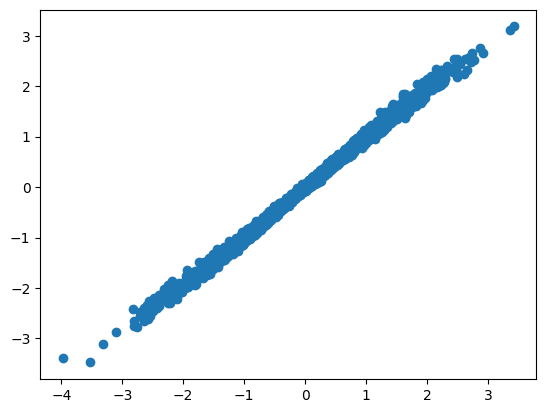

In [69]:
with torch.no_grad():
    plt.figure()
    torch.manual_seed(42)
    X = torch.randn(3000, 150)
    plt.scatter(X[:,0], model(X).mean(axis=1))

SECTION 9C: KRR COMPONENTS VS EK THEORY COMPONENTS

KRR decomposed into Hermite components:
  Linear coefficient: -0.001117
  Cubic coefficient:  0.000634

KRR vs EK Theory Metrics:
  Linear: MSE=0.999232, R²=-799970.9984
  Cubic:  MSE=0.000006, R²=-1.1346


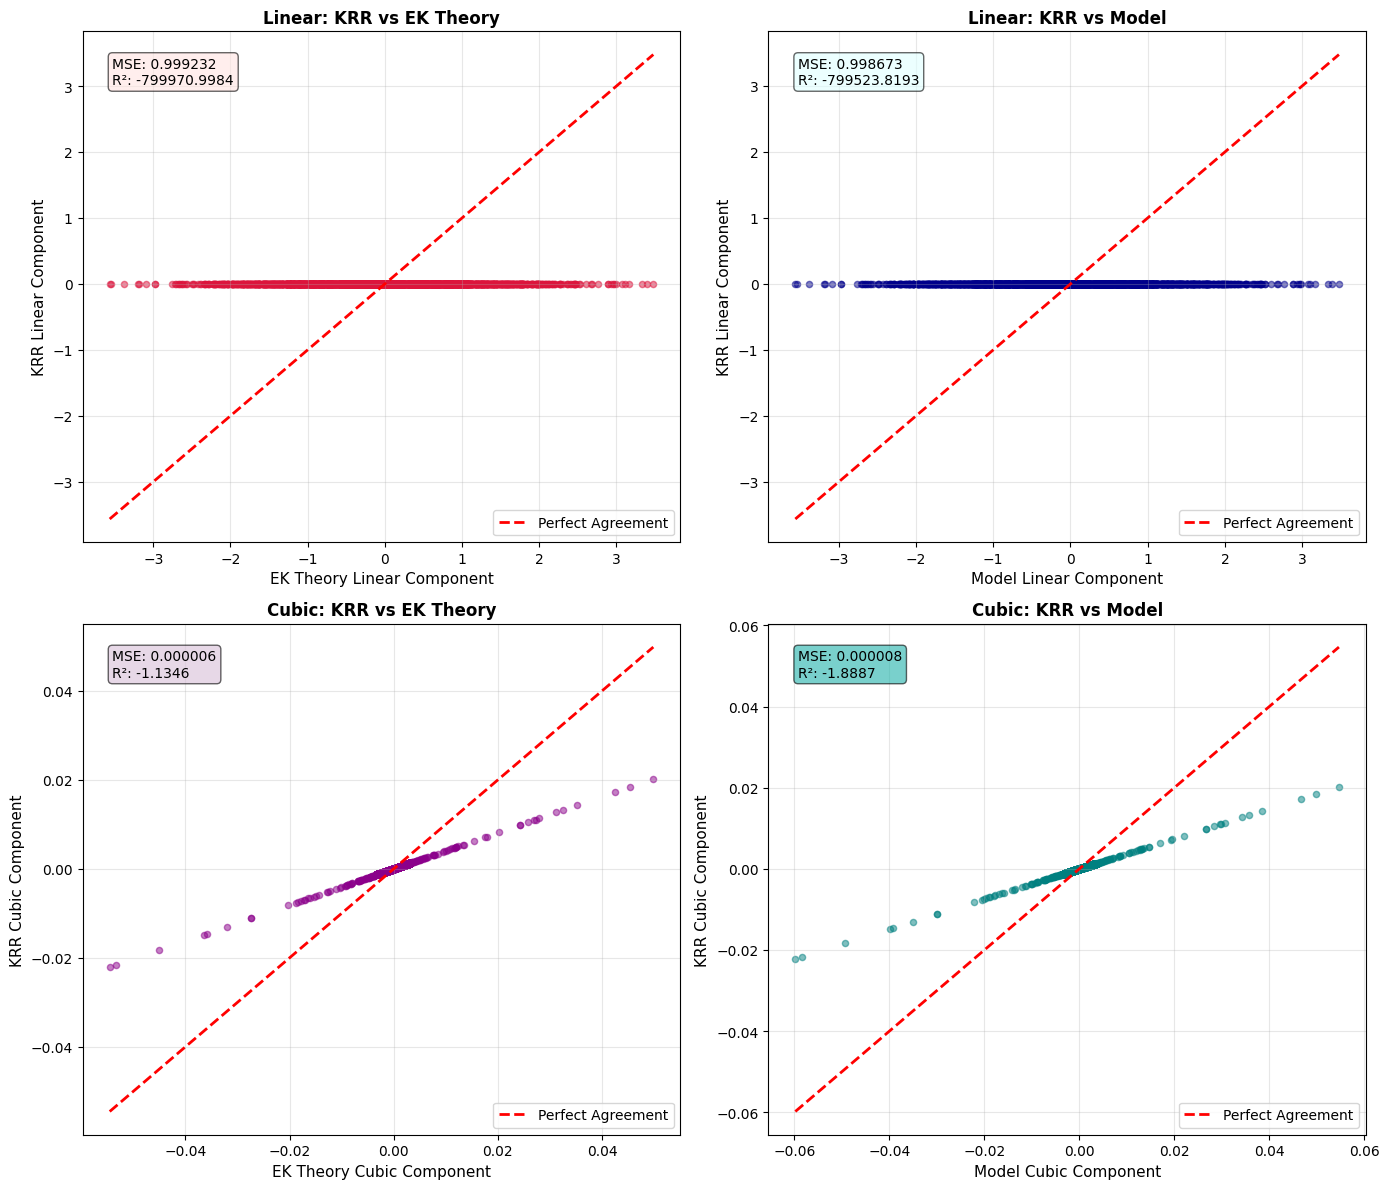


Saved plot to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/section9c_krr_vs_ek_theory_and_model_components.png


In [73]:
print("=" * 60)
print("SECTION 9C: KRR COMPONENTS VS EK THEORY COMPONENTS")
print("=" * 60)

# Decompose KRR predictions into linear and cubic Hermite components
A_krr = np.column_stack([he1_test_norm, he3_test_norm])
coef_krr_comp, _, _, _ = np.linalg.lstsq(A_krr, y_krr_test, rcond=None)

y_krr_linear_comp = coef_krr_comp[0] * he1_test_norm
y_krr_cubic_comp = coef_krr_comp[1] * he3_test_norm

print(f"\nKRR decomposed into Hermite components:")
print(f"  Linear coefficient: {coef_krr_comp[0]:.6f}")
print(f"  Cubic coefficient:  {coef_krr_comp[1]:.6f}")

# Compute metrics: KRR vs EK Theory for both components
# Linear: KRR vs Theory
mse_krr_vs_theory_lin = np.mean((y_krr_linear_comp - y_theory_linear) ** 2)
r2_krr_vs_theory_lin = 1 - np.sum((y_krr_linear_comp - y_theory_linear) ** 2) / np.sum((y_krr_linear_comp - y_krr_linear_comp.mean()) ** 2)

# Cubic: KRR vs Theory
mse_krr_vs_theory_cub = np.mean((y_krr_cubic_comp - y_theory_cubic) ** 2)
r2_krr_vs_theory_cub = 1 - np.sum((y_krr_cubic_comp - y_theory_cubic) ** 2) / np.sum((y_krr_cubic_comp - y_krr_cubic_comp.mean()) ** 2)

print(f"\nKRR vs EK Theory Metrics:")
print(f"  Linear: MSE={mse_krr_vs_theory_lin:.6f}, R²={r2_krr_vs_theory_lin:.4f}")
print(f"  Cubic:  MSE={mse_krr_vs_theory_cub:.6f}, R²={r2_krr_vs_theory_cub:.4f}")

# Create 2x2 figure: KRR vs Theory (linear and cubic) + KRR vs Model (linear and cubic)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ---------- Linear: KRR vs EK Theory ----------
ax = axes[0, 0]
ax.scatter(y_theory_linear, y_krr_linear_comp, alpha=0.5, s=20, color='crimson')
lin_min_kt = min(y_theory_linear.min(), y_krr_linear_comp.min())
lin_max_kt = max(y_theory_linear.max(), y_krr_linear_comp.max())
ax.plot([lin_min_kt, lin_max_kt], [lin_min_kt, lin_max_kt], 'r--', lw=2, label='Perfect Agreement')
ax.set_xlabel('EK Theory Linear Component', fontsize=11)
ax.set_ylabel('KRR Linear Component', fontsize=11)
ax.set_title('Linear: KRR vs EK Theory', fontsize=12, fontweight='bold')
ax.text(
    0.05, 0.95, f'MSE: {mse_krr_vs_theory_lin:.6f}\nR²: {r2_krr_vs_theory_lin:.4f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='mistyrose', alpha=0.6)
)
ax.legend()
ax.grid(True, alpha=0.3)

# ---------- Linear: KRR vs Model ----------
ax = axes[0, 1]
mse_krr_vs_model_lin = np.mean((y_krr_linear_comp - y_model_linear) ** 2)
r2_krr_vs_model_lin = 1 - np.sum((y_krr_linear_comp - y_model_linear) ** 2) / np.sum((y_krr_linear_comp - y_krr_linear_comp.mean()) ** 2)
ax.scatter(y_model_linear, y_krr_linear_comp, alpha=0.5, s=20, color='darkblue')
lin_min_km = min(y_model_linear.min(), y_krr_linear_comp.min())
lin_max_km = max(y_model_linear.max(), y_krr_linear_comp.max())
ax.plot([lin_min_km, lin_max_km], [lin_min_km, lin_max_km], 'r--', lw=2, label='Perfect Agreement')
ax.set_xlabel('Model Linear Component', fontsize=11)
ax.set_ylabel('KRR Linear Component', fontsize=11)
ax.set_title('Linear: KRR vs Model', fontsize=12, fontweight='bold')
ax.text(
    0.05, 0.95, f'MSE: {mse_krr_vs_model_lin:.6f}\nR²: {r2_krr_vs_model_lin:.4f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.6)
)
ax.legend()
ax.grid(True, alpha=0.3)

# ---------- Cubic: KRR vs EK Theory ----------
ax = axes[1, 0]
ax.scatter(y_theory_cubic, y_krr_cubic_comp, alpha=0.5, s=20, color='darkmagenta')
cub_min_kt = min(y_theory_cubic.min(), y_krr_cubic_comp.min())
cub_max_kt = max(y_theory_cubic.max(), y_krr_cubic_comp.max())
ax.plot([cub_min_kt, cub_max_kt], [cub_min_kt, cub_max_kt], 'r--', lw=2, label='Perfect Agreement')
ax.set_xlabel('EK Theory Cubic Component', fontsize=11)
ax.set_ylabel('KRR Cubic Component', fontsize=11)
ax.set_title('Cubic: KRR vs EK Theory', fontsize=12, fontweight='bold')
ax.text(
    0.05, 0.95, f'MSE: {mse_krr_vs_theory_cub:.6f}\nR²: {r2_krr_vs_theory_cub:.4f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='thistle', alpha=0.6)
)
ax.legend()
ax.grid(True, alpha=0.3)

# ---------- Cubic: KRR vs Model ----------
ax = axes[1, 1]
mse_krr_vs_model_cub = np.mean((y_krr_cubic_comp - y_model_cubic) ** 2)
r2_krr_vs_model_cub = 1 - np.sum((y_krr_cubic_comp - y_model_cubic) ** 2) / np.sum((y_krr_cubic_comp - y_krr_cubic_comp.mean()) ** 2)
ax.scatter(y_model_cubic, y_krr_cubic_comp, alpha=0.5, s=20, color='teal')
cub_min_km = min(y_model_cubic.min(), y_krr_cubic_comp.min())
cub_max_km = max(y_model_cubic.max(), y_krr_cubic_comp.max())
ax.plot([cub_min_km, cub_max_km], [cub_min_km, cub_max_km], 'r--', lw=2, label='Perfect Agreement')
ax.set_xlabel('Model Cubic Component', fontsize=11)
ax.set_ylabel('KRR Cubic Component', fontsize=11)
ax.set_title('Cubic: KRR vs Model', fontsize=12, fontweight='bold')
ax.text(
    0.05, 0.95, f'MSE: {mse_krr_vs_model_cub:.6f}\nR²: {r2_krr_vs_model_cub:.4f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='lightseagreen', alpha=0.6)
)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_dir / 'section9c_krr_vs_ek_theory_and_model_components.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved plot to {base_dir / 'section9c_krr_vs_ek_theory_and_model_components.png'}")
print("=" * 60)

Regenerating X_test (n=3000, dim=150) with seed=76...
Computing training set preactivations...
Computing preactivations for REGENERATED test set...


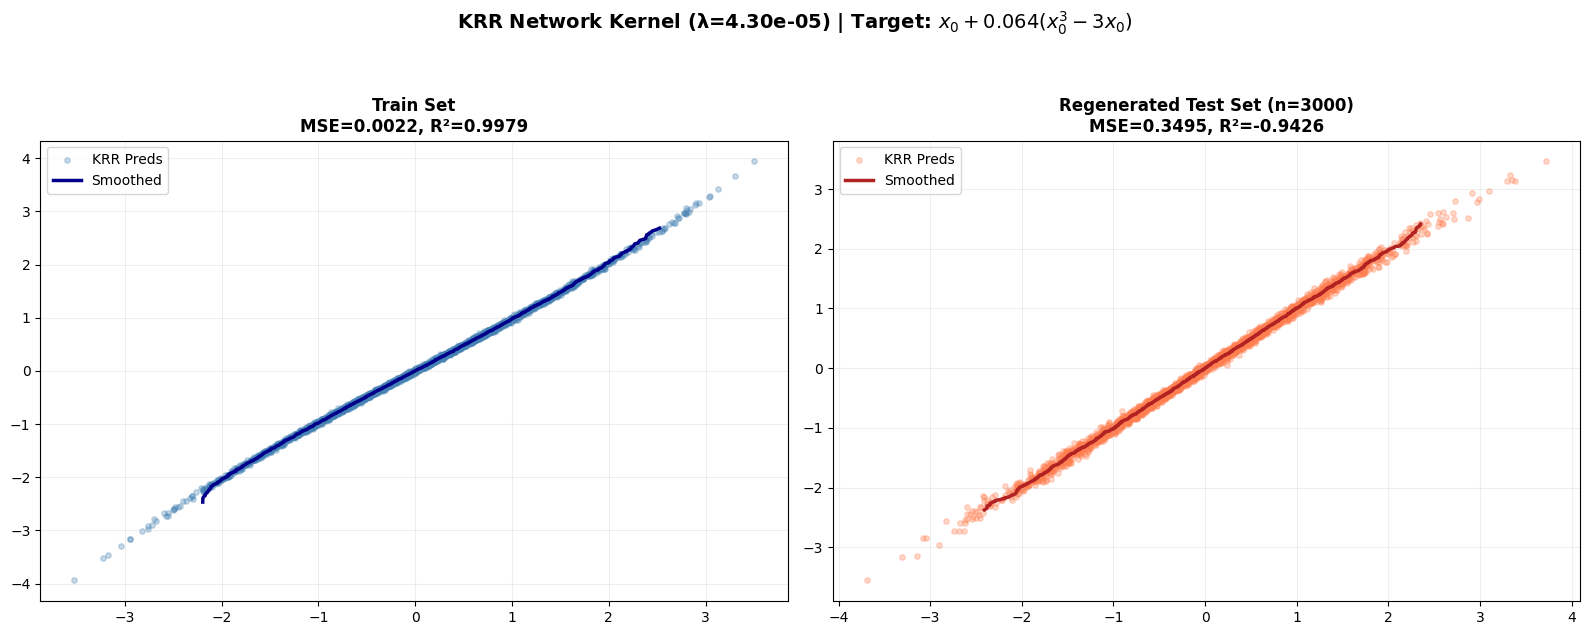

Done. Test metrics represent true generalization (Seed 76


In [108]:
# ==============================================================================
# SECTION: REGENERATE TEST DATA & COMPUTE KRR WITH NETWORK KERNEL MATRIX
# ==============================================================================
import numpy as np
import torch
import matplotlib.pyplot as plt
n_test = 3000
input_dim = d

test_seed = 42 + 34
test_rng = np.random.default_rng(seed=test_seed)

print(f"Regenerating X_test (n={n_test}, dim={input_dim}) with seed={test_seed}...")

# Generate features: Independent samples for the test set
X_test_np = test_rng.standard_normal(size=(n_test, input_dim)).astype(np.float32)

# Define the specific target function: x0 + 0.064 * (x0^3 - 3*x0)
def target_function(x):
    x0 = x[:, 0]
    return (x0 + 0.074 * (x0**3 - 3 * x0)) / 6**0.5

y_test_true = target_function(X_test_np)

# 2. DEFINE KERNEL FUNCTION
def K_kernel(h1_a, h1_b):
    """Compute kernel matrix from preactivations h1_a and h1_b."""
    # LaTeX: K(x_i, x_j) = \frac{1}{n_2 \cdot ens} \sum h(x_i)h(x_j)^T
    hh_inf_i = torch.einsum('uim,vim->uvi', h1_a, h1_b) / (model.n2 * h1_a.shape[0])
    hh_inf = torch.sum(hh_inf_i, axis=2) / model.ens
    return hh_inf

# 3. TRAINING KERNEL & KRR SOLVE
print("Computing training set preactivations...")
X_train_torch = torch.from_numpy(X_large_np).float().to(device)
with torch.no_grad():
    h1_train = model.h1_preactivation(X_train_torch)
    K_train_torch = K_kernel(h1_train, h1_train)
    K_train = K_train_torch.cpu().numpy()

# Solve KRR: alpha = (K + λI)⁻¹ y
lam = effective_ridge if 'effective_ridge' in locals() else 1e-3
K_train_reg = K_train + lam * np.eye(K_train.shape[0])
y_train_vec = y_target_large_np
alpha_krr = np.linalg.solve(K_train_reg, y_train_vec)

# 4. TEST KERNEL (Using the NEW X_test)
print("Computing preactivations for REGENERATED test set...")
X_test_torch = torch.from_numpy(X_test_np).float().to(device)
with torch.no_grad():
    h1_test = model.h1_preactivation(X_test_torch)
    K_test_train_torch = K_kernel(h1_test, h1_train)
    K_test_train = K_test_train_torch.cpu().numpy()

# 5. PREDICTIONS & METRICS
y_krr_train = K_train @ alpha_krr
y_krr_test = K_test_train @ alpha_krr

mse_train = np.mean((y_krr_train - y_train_vec)**2)
r2_train = 1 - np.sum((y_krr_train - y_train_vec)**2) / np.sum((y_train_vec - y_train_vec.mean())**2)
mse_test = np.mean((y_krr_test - y_test_true)**2)
r2_test = 1 - np.sum((y_krr_test - y_test_true)**2) / np.sum((y_test_true - y_test_true.mean())**2)

# 6. PLOTTING
x0_train = X_large_np[:, 0]
x0_test = X_test_np[:, 0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# TRAIN SUBPLOT
ax_train = axes[0]
sort_idx_train = np.argsort(x0_train)
x0_t_s = x0_train[sort_idx_train]
y_t_s = y_krr_train[sort_idx_train]

ax_train.scatter(x0_t_s, y_t_s, alpha=0.3, s=15, color='steelblue', label='KRR Preds')
win_tr = max(30, len(y_t_s) // 50)
y_tr_smooth = np.convolve(y_t_s, np.ones(win_tr)/win_tr, mode='valid')
x_tr_smooth = x0_t_s[win_tr//2 : win_tr//2 + len(y_tr_smooth)]
ax_train.plot(x_tr_smooth, y_tr_smooth, color='darkblue', lw=2.5, label='Smoothed')
ax_train.set_title(f'Train Set\nMSE={mse_train:.4f}, R²={r2_train:.4f}', fontweight='bold')
ax_train.grid(True, alpha=0.2); ax_train.legend()

# TEST SUBPLOT (REGENERATED)
ax_test = axes[1]
sort_idx_test = np.argsort(x0_test)
x0_v_s = x0_test[sort_idx_test]
y_v_s = y_krr_test[sort_idx_test]

ax_test.scatter(x0_v_s, y_v_s, alpha=0.3, s=15, color='coral', label='KRR Preds')
win_te = max(30, len(y_v_s) // 50)
y_te_smooth = np.convolve(y_v_s, np.ones(win_te)/win_te, mode='valid')
x_te_smooth = x0_v_s[win_te//2 : win_te//2 + len(y_te_smooth)]
ax_test.plot(x_te_smooth, y_te_smooth, color='firebrick', lw=2.5, label='Smoothed')
ax_test.set_title(f'Regenerated Test Set (n={n_test})\nMSE={mse_test:.4f}, R²={r2_test:.4f}', fontweight='bold')
ax_test.grid(True, alpha=0.2); ax_test.legend()

fig.suptitle(f'KRR Network Kernel (λ={lam:.2e}) | Target: $x_0 + 0.064(x_0^3 - 3x_0)$', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print(f"Done. Test metrics represent true generalization (Seed {test_seed}")

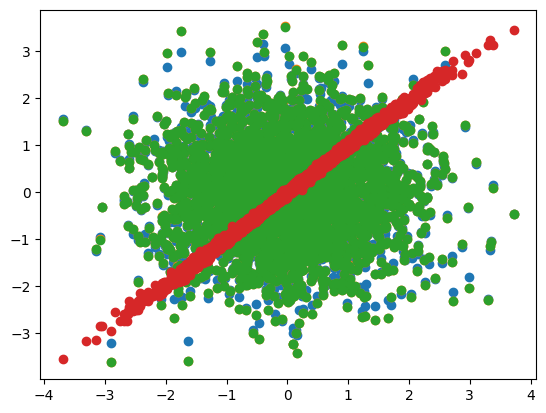

In [118]:
for label, y_vals in y_test_dict.items():
    if y_vals is not None:
        
        plt.scatter(X_test_np[:,0], y_vals)
        h1_p = compute_projection(y_vals, he1_test_vec, 1.0)
        y_res = y_vals - h1_p * he1_test_vec
        # proj = compute_projection(y_res, he3_test_vec, norm_factor)
        # print(f"  {label:10}: {proj:.8f}")

In [ ]:
print("=" * 70)
print("SECTION: He3 PROJECTIONS FOR MODEL, EK, EK_THEORY, AND KRR")
print("=" * 70)

# Normalization factor for He3: 0.03 * sqrt(6)
norm_factor = 0.03 * np.sqrt(6)
print(f"\nNormalization factor: 0.03 * sqrt(6) = {norm_factor:.6f}\n")

# --- Basis Vector Computation (He1 and He3 on x0) ---
# He1(x0) = x0
# He3(x0) = x0^3 - 3*x0
he1_train_vec = X_large_np[:, 0]
he3_train_vec = (X_large_np[:, 0]**3 - 3 * X_large_np[:, 0])/6**0.5

# IMPORTANT: Use the REGENERATED X_test_np for test basis vectors
he1_test_vec = X_test_np[:, 0]
he3_test_vec = (X_test_np[:, 0]**3 - 3 * X_test_np[:, 0]) /6**0.5

def compute_projection(y_pred, basis_vec, norm=1.0):
    """Computes the empirical projection of predictions onto a basis vector."""
    if y_pred is None or basis_vec is None:
        return None
    return np.dot(y_pred, basis_vec) / len(y_pred) / norm

# ============================================================================
# TRAIN SET PROJECTIONS
# ============================================================================
print("\n" + "=" * 70)
print("TRAIN SET PROJECTIONS")
print("=" * 70)

y_model = 
y_ek_empirical = 
y_ek_theory = 
# Collecting predictions (matching your naming convention)
y_train_dict = {
    "Model":     y_model if 'y_model' in locals() else None,
    "EK Emp":    y_ek_empirical if 'y_ek_empirical' in locals() else None,
    "EK Theory": y_ek_theory if 'y_ek_theory' in locals() else None,
    "KRR":       y_krr_train # From our recent regenerated run
}

print(f"He3 Projections (divided by {norm_factor:.6f}):")
for label, y_vals in y_train_dict.items():
    proj = compute_projection(y_vals, he3_train_vec, norm_factor)
    if proj is not None:
        print(f"  {label:10}: {proj:.8f}")

# He1-subtracted projections (orthogonality check)
print(f"\nHe3 Projections (He1-subtracted, divided by {norm_factor:.6f}):")
for label, y_vals in y_train_dict.items():
    if y_vals is not None:
        h1_p = compute_projection(y_vals, he1_train_vec, 1.0)
        # Remove He1 component: y_orthogonal = y - <y, He1> * He1
        y_res = y_vals - h1_p * he1_train_vec
        proj = compute_projection(y_res, he3_train_vec, norm_factor)
        print(f"  {label:10}: {proj:.8f}")

# ============================================================================
# TEST SET PROJECTIONS (Independent Samples)
# ============================================================================
print("\n" + "=" * 70)
print("TEST SET PROJECTIONS (REGENERATED)")
print("=" * 70)

y_test_dict = {
    "Model":     y_model_test if 'y_model_test' in locals() else None,
    "EK Emp":    y_ek_empirical_test if 'y_ek_empirical_test' in locals() else None,
    "EK Theory": y_ek_theory_test if 'y_ek_theory_test' in locals() else None,
    "KRR":       y_krr_test # From our recent regenerated run
}

print(f"He3 Projections (divided by {norm_factor:.6f}):")
for label, y_vals in y_test_dict.items():
    proj = compute_projection(y_vals, he3_test_vec, norm_factor)
    if proj is not None:
        print(f"  {label:10}: {proj:.8f}")

print(f"\nHe3 Projections (He1-subtracted, divided by {norm_factor:.6f}):")
for label, y_vals in y_test_dict.items():
    if y_vals is not None:
        h1_p = compute_projection(y_vals, he1_test_vec, 1.0)
        y_res = y_vals - h1_p * he1_test_vec
        proj = compute_projection(y_res, he3_test_vec, norm_factor)
        print(f"  {label:10}: {proj:.8f}")

print("\n" + "=" * 70)

SECTION: He3 PROJECTIONS FOR MODEL, EK, EK_THEORY, AND KRR

Normalization factor: 0.03 * sqrt(6) = 0.073485


TRAIN SET PROJECTIONS
He3 Projections (divided by 0.073485):
  Model     : 0.79616593
  EK Emp    : 0.64532312
  EK Theory : 0.64024977
  KRR       : 1.04869603

He3 Projections (He1-subtracted, divided by 0.073485):
  Model     : 0.18595536
  EK Emp    : 0.03574639
  EK Theory : 0.03051189
  KRR       : 0.43650028

TEST SET PROJECTIONS (REGENERATED)
He3 Projections (divided by 0.073485):
  Model     : -0.37052576
  EK Emp    : -0.35397966
  EK Theory : -0.35426992
  KRR       : 0.57387096

He3 Projections (He1-subtracted, divided by 0.073485):
  Model     : -0.37322716
  EK Emp    : -0.35687695
  EK Theory : -0.35716863
  KRR       : -0.19713531



In [106]:
print("=" * 70)
print("THEORETICAL LEARNABILITY RATIO")
print("=" * 70)

# Theoretical learnability ratio: λK3_theory / (λK3_theory + κ_eff/P)
if 'lK3T_theory' in locals() and 'kappa_eff_theory' in locals() and 'P' in locals():
    learnability_ratio = lK3T_theory / (lK3T_theory + kappa_eff_theory / P)
    print(f"\nParameters:")
    print(f"  λK3_theory = {lK3T_theory:.8f}")
    print(f"  κ_eff = {kappa_eff_theory:.8f}")
    print(f"  P = {P}")
    print(f"\nLearnability Ratio = λK3_theory / (λK3_theory + κ_eff/P)")
    print(f"  = {lK3T_theory:.8f} / ({lK3T_theory:.8f} + {kappa_eff_theory/P:.8f})")
    print(f"  = {lK3T_theory:.8f} / {lK3T_theory + kappa_eff_theory/P:.8f}")
    print(f"  = {learnability_ratio:.8f}")
else:
    print("Missing required variables: lK3T_theory, kappa_eff_theory, or P")

print("\n" + "=" * 70)

THEORETICAL LEARNABILITY RATIO

Parameters:
  λK3_theory = 0.00000236
  κ_eff = 0.12900000
  P = 3000

Learnability Ratio = λK3_theory / (λK3_theory + κ_eff/P)
  = 0.00000236 / (0.00000236 + 0.00004300)
  = 0.00000236 / 0.00004536
  = 0.05203296



## Section 10: EK Theory vs Kernel Ridge Regression [K(K + κ)^{-1}]

Compare EK theory predictions against kernel ridge regression using the covariance matrix of network h1 preactivations.

In [195]:
model.h1_activation(X_large).shape

torch.Size([3000, 10, 1600])

In [65]:
y_true_test.shape

(1000,)

KERNEL RIDGE REGRESSION (KRR) ANALYSIS
Training h1 preactivations shape (before avg): (3000, 5, 1600)
Training h1 preactivations shape: (3000, 5, 1600)
Training targets shape: (3000,)
Test h1 preactivations shape (before avg): (3000, 5, 1600)
Test h1 preactivations shape: (3000, 5, 1600)

Computing kernel matrices...
K_train shape: (3000, 3000), conditioning number: 9.85e+03
K_test_train shape: (3000, 3000)

Applying kernel ridge regression with κ_eff = 0.129000
Successfully solved ridge system
KRR predictions shape: (3000,)

Kernel Ridge Regression Metrics (Test Set):
  MSE: 1.027207
  R²:  -0.0139

EK Theory Metrics (Test Set, from previous):
  MSE: 0.005570
  R²:  0.9945


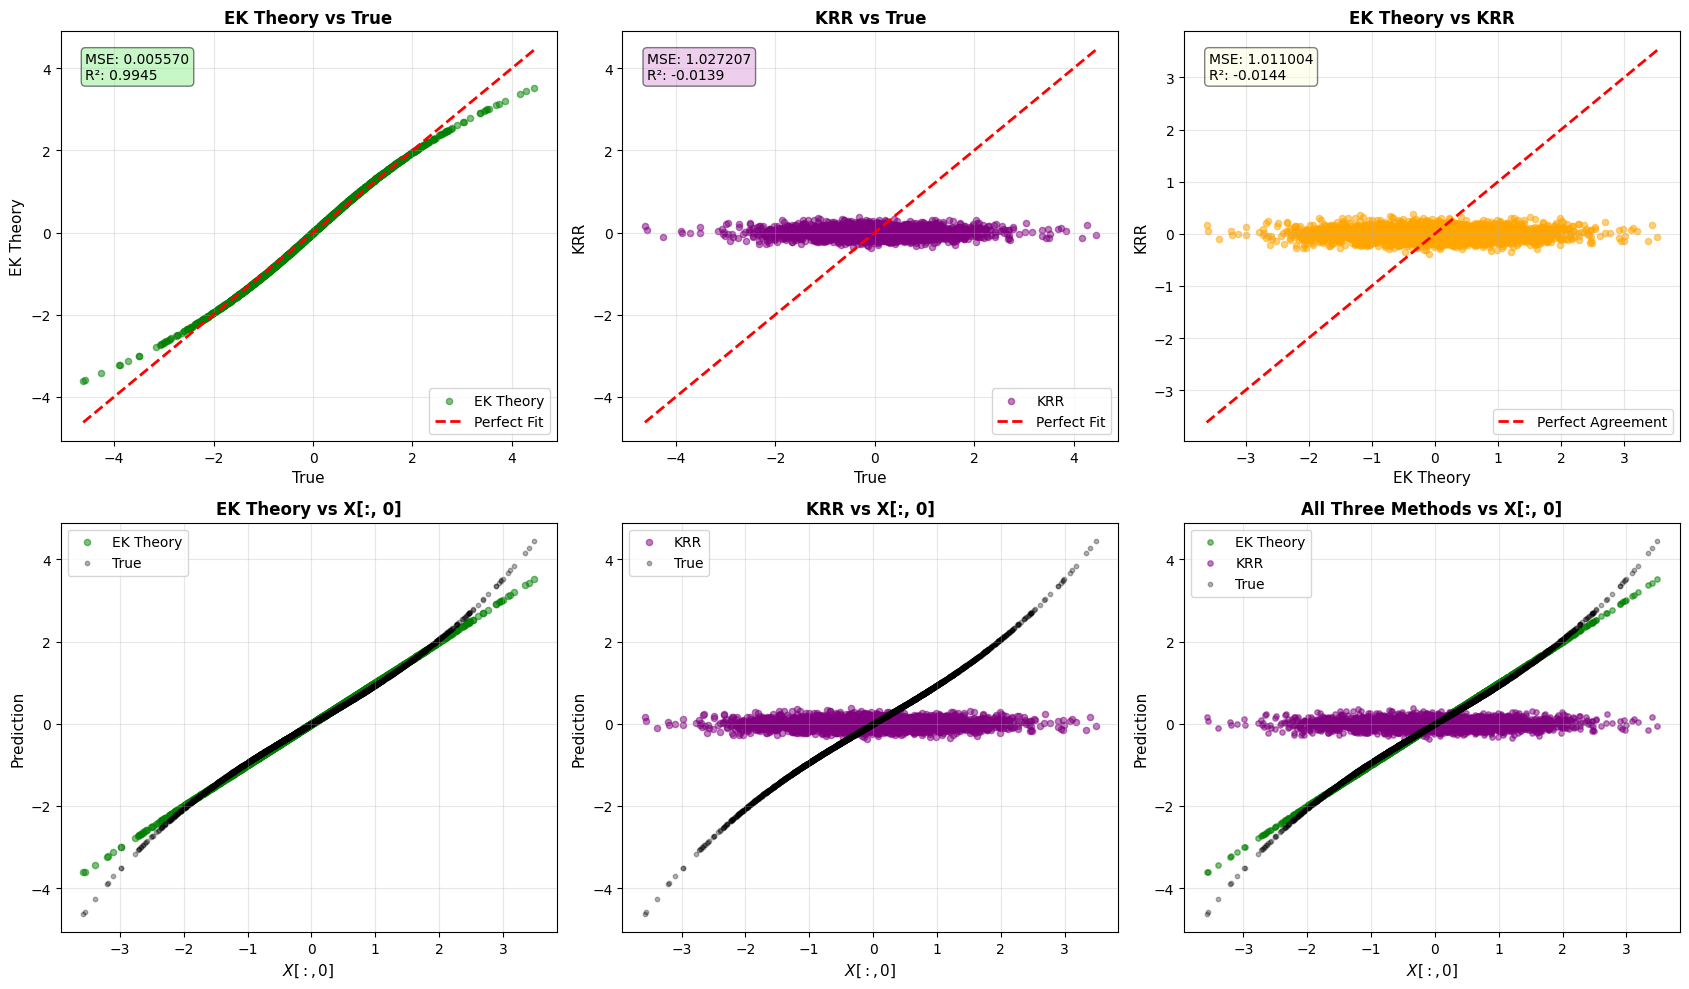


Plot saved to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/ek_theory_vs_krr_comparison.png


In [74]:
print("="*60)
print("KERNEL RIDGE REGRESSION (KRR) ANALYSIS")
print("="*60)

# === Extract h1 preactivations from training and test sets ===

# Training data from the training seed
h1_train_list = []
y_train_list = []

batch_size = 100
with torch.no_grad():
    for batch_idx in range(0, 3000, batch_size):
        batch_end = min(batch_idx + batch_size, P)
        X_batch = X_large[batch_idx:batch_end].to(device)
        
        # Get h1 preactivations (before activation function)
        # Model architecture: input -> W0 @ x + b0 = h1_pre, then erf(h1_pre) = h1
        h1_pre = model.h1_activation(X_batch)  # Shape: (batch_size, N)
        h1_train_list.append(h1_pre.cpu().numpy())
        
        # Get corresponding true targets
        y_batch = torch.from_numpy(y_target_large[batch_idx:batch_end]).float().to(device)
        y_train_list.append(y_batch.cpu().numpy())

h1_train = np.concatenate(h1_train_list, axis=0)  # Shape: (P, ens, N) or (P, N)
y_train = np.concatenate(y_train_list, axis=0)     # Shape: (P,)

# Handle ensemble dimension if present
if len(h1_train.shape) == 3:
    print(f"Training h1 preactivations shape (before avg): {h1_train.shape}")
    # h1_train = h1_train.mean(axis=1)  # Average over ensemble: (P, ens, N) -> (P, N)

print(f"Training h1 preactivations shape: {h1_train.shape}")
print(f"Training targets shape: {y_train.shape}")

# Test set h1 preactivations
h1_test_list = []
N_test = P
with torch.no_grad():
    for batch_idx in range(0, N_test, batch_size):
        batch_end = min(batch_idx + batch_size, N_test)
        X_batch = X_test_gen[batch_idx:batch_end].to(device)
        h1_pre = model.h1_activation(X_batch)
        h1_test_list.append(h1_pre.cpu().numpy())

h1_test = np.concatenate(h1_test_list, axis=0)  # Shape: (N_test, ens, N) or (N_test, N)

# Handle ensemble dimension if present
if len(h1_test.shape) == 3:
    print(f"Test h1 preactivations shape (before avg): {h1_test.shape}")
    # h1_test = h1_test.mean(axis=1)  # Average over ensemble: (N_test, ens, N) -> (N_test, N)

print(f"Test h1 preactivations shape: {h1_test.shape}")

# === Compute Kernel Matrices ===
# K_train = (1/P) * h1_train @ h1_train.T  (Gram matrix: P x P)
# K_test_train = (1/P) * h1_test @ h1_train.T  (Cross kernel: N_test x P)

def K_kernel(h1_a, h1_b):
    hh_inf_i = torch.einsum('uim,vim->uvi', h1_a,
                            h1_b)/(model.n2 * h1_a.shape[0])
    hh_inf = torch.sum(hh_inf_i, axis=2) / model.ens
    return hh_inf

print("\nComputing kernel matrices...")
K_train = K_kernel(torch.from_numpy(h1_train), torch.from_numpy(h1_train)).numpy()
K_test_train = K_kernel(torch.from_numpy(h1_train), torch.from_numpy(h1_train)).numpy()



print(f"K_train shape: {K_train.shape}, conditioning number: {np.linalg.cond(K_train):.2e}")
print(f"K_test_train shape: {K_test_train.shape}")

# === Kernel Ridge Regression ===
# Predictions: y_pred = K_test_train @ inv(K_train + κI) @ y_train

print(f"\nApplying kernel ridge regression with κ_eff = {kappa_eff_theory:.6f}")

# Add regularization to training kernel
K_train_reg = K_train + kappa_eff_theory * np.eye(P)

# Solve for alpha coefficients: alpha = (K_train + κI)^{-1} @ y_train
try:
    alpha_krr = np.linalg.solve(K_train_reg, y_train)
    print(f"Successfully solved ridge system")
except np.linalg.LinAlgError:
    print(f"Warning: Using lstsq instead of solve due to singular matrix")
    alpha_krr, _, _, _ = np.linalg.lstsq(K_train_reg, y_train, rcond=None)

try:
    # Make predictions on test set
    y_krr_test = K_test_train @ alpha_krr

    print(f"KRR predictions shape: {y_krr_test.shape}")
except Exception as e:
    print(f"Error during KRR prediction: {e}")
    y_krr_test = np.zeros(N_test)  # Fallback to zeros if prediction fails

try:
    # === Compute Metrics ===
    mse_krr = np.mean((y_true_test - y_krr_test) ** 2)
    r2_krr = 1.0 - np.sum((y_true_test - y_krr_test)**2) / np.sum((y_true_test - y_true_test.mean())**2)

    print(f"\nKernel Ridge Regression Metrics (Test Set):")
    print(f"  MSE: {mse_krr:.6f}")
    print(f"  R²:  {r2_krr:.4f}")
except Exception as e:
    print(f"Error computing KRR metrics: {e}")

try: 
    print(f"\nEK Theory Metrics (Test Set, from previous):")
    print(f"  MSE: {mse_ek_theory_test:.6f}")
    print(f"  R²:  {r2_ek_theory_test:.4f}")
except Exception as e:
    print(f"Error printing EK Theory metrics: {e}")
# === Visualization: KRR vs EK Theory ===
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

# Row 1: Full predictions
# Plot 1: EK Theory vs True
ax = axes[0, 0]
ax.scatter(y_true_test, y_ek_theory_test, alpha=0.5, s=20, color='green', label='EK Theory')
min_val = min(y_true_test.min(), y_ek_theory_test.min())
max_val = max(y_true_test.max(), y_ek_theory_test.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('True', fontsize=11)
ax.set_ylabel('EK Theory', fontsize=11)
ax.set_title('EK Theory vs True', fontsize=12, fontweight='bold')
ax.text(0.05, 0.95, f'MSE: {mse_ek_theory_test:.6f}\nR²: {r2_ek_theory_test:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: KRR vs True
ax = axes[0, 1]
ax.scatter(y_true_test, y_krr_test, alpha=0.5, s=20, color='purple', label='KRR')
min_val = min(y_true_test.min(), y_krr_test.min())
max_val = max(y_true_test.max(), y_krr_test.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('True', fontsize=11)
ax.set_ylabel('KRR', fontsize=11)
ax.set_title('KRR vs True', fontsize=12, fontweight='bold')
ax.text(0.05, 0.95, f'MSE: {mse_krr:.6f}\nR²: {r2_krr:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='plum', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: EK Theory vs KRR
ax = axes[0, 2]
ax.scatter(y_ek_theory_test, y_krr_test, alpha=0.5, s=20, color='orange')
min_val = min(y_ek_theory_test.min(), y_krr_test.min())
max_val = max(y_ek_theory_test.max(), y_krr_test.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Agreement')
mse_theory_krr = np.mean((y_ek_theory_test - y_krr_test)**2)
r2_theory_krr = 1.0 - np.sum((y_ek_theory_test - y_krr_test)**2) / np.sum((y_ek_theory_test - y_ek_theory_test.mean())**2)
ax.set_xlabel('EK Theory', fontsize=11)
ax.set_ylabel('KRR', fontsize=11)
ax.set_title('EK Theory vs KRR', fontsize=12, fontweight='bold')
ax.text(0.05, 0.95, f'MSE: {mse_theory_krr:.6f}\nR²: {r2_theory_krr:.4f}', 
        transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
ax.legend()
ax.grid(True, alpha=0.3)

# Row 2: vs X[:, 0]
sort_idx_krr = np.argsort(x0_sorted)

# Plot 4: EK Theory vs X[:, 0]
ax = axes[1, 0]
ax.scatter(x0_sorted[sort_idx_krr], y_ek_theory_test[sort_idx_test][sort_idx_krr], alpha=0.5, s=20, color='green', label='EK Theory')
ax.scatter(x0_sorted[sort_idx_krr], y_true_test[sort_idx_test][sort_idx_krr], alpha=0.3, s=10, color='black', label='True')
ax.set_xlabel(r'$X[:,0]$', fontsize=11)
ax.set_ylabel('Prediction', fontsize=11)
ax.set_title('EK Theory vs X[:, 0]', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: KRR vs X[:, 0]
ax = axes[1, 1]
ax.scatter(x0_sorted[sort_idx_krr], y_krr_test[sort_idx_test][sort_idx_krr], alpha=0.5, s=20, color='purple', label='KRR')
ax.scatter(x0_sorted[sort_idx_krr], y_true_test[sort_idx_test][sort_idx_krr], alpha=0.3, s=10, color='black', label='True')
ax.set_xlabel(r'$X[:,0]$', fontsize=11)
ax.set_ylabel('Prediction', fontsize=11)
ax.set_title('KRR vs X[:, 0]', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: Comparison all three
ax = axes[1, 2]
ax.scatter(x0_sorted[sort_idx_krr], y_ek_theory_test[sort_idx_test][sort_idx_krr], alpha=0.5, s=15, color='green', label='EK Theory')
ax.scatter(x0_sorted[sort_idx_krr], y_krr_test[sort_idx_test][sort_idx_krr], alpha=0.5, s=15, color='purple', label='KRR')
ax.scatter(x0_sorted[sort_idx_krr], y_true_test[sort_idx_test][sort_idx_krr], alpha=0.3, s=10, color='black', label='True')
ax.set_xlabel(r'$X[:,0]$', fontsize=11)
ax.set_ylabel('Prediction', fontsize=11)
ax.set_title('All Three Methods vs X[:, 0]', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_dir / 'ek_theory_vs_krr_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to {base_dir / 'ek_theory_vs_krr_comparison.png'}")
print("="*60)

In [187]:
h1_train.shape

(1105, 1600)

## Section 10b: KRR Component-wise Comparisons

Compare KRR component projections against EK theory, EK empirical, true components, and model components for both linear and cubic terms.

KRR COMPONENT-WISE COMPARISONS
KRR component coefficients: linear=-0.001117, cubic=0.000634


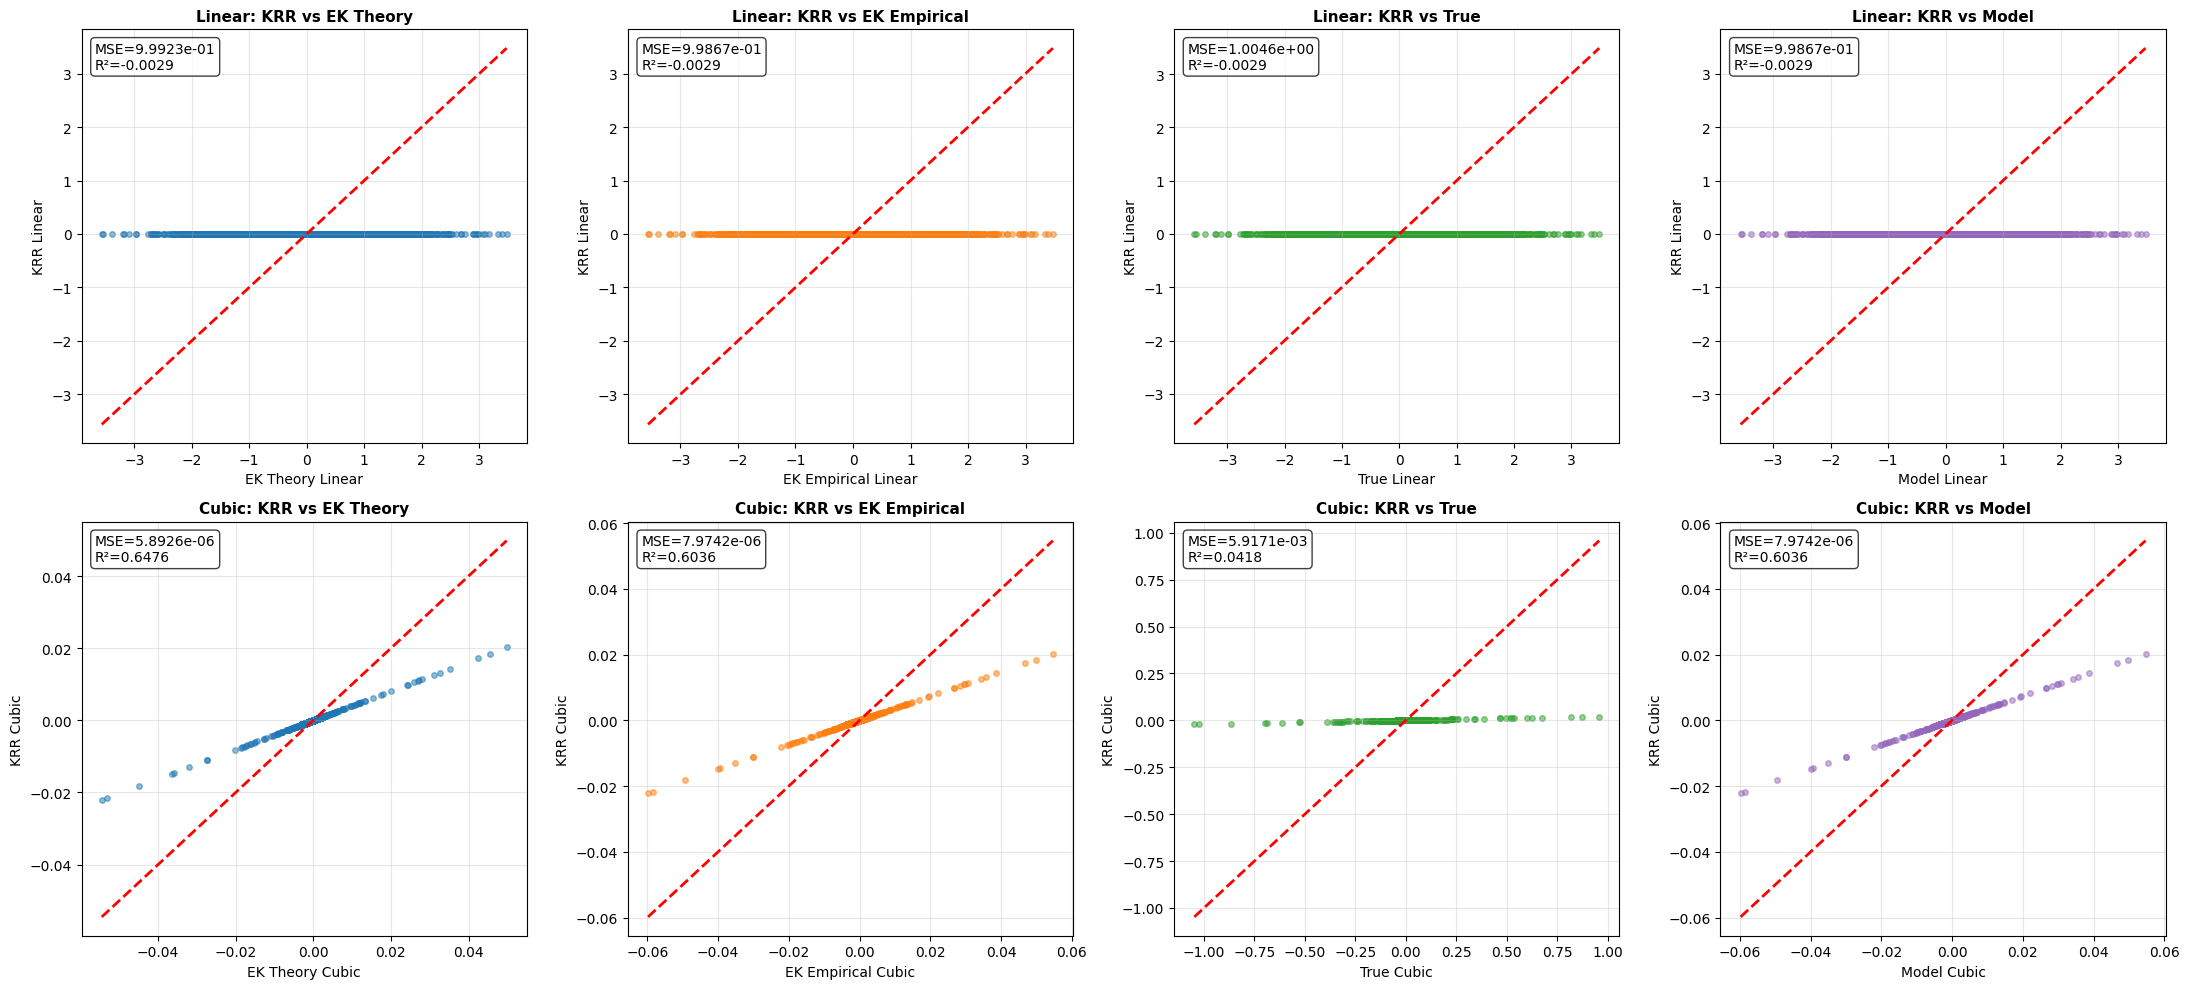

Saved plot to /home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/results/d150_P3000_N1600_chi50_kappa0.1/krr_componentwise_comparisons.png


In [75]:
print("=" * 60)
print("KRR COMPONENT-WISE COMPARISONS")
print("=" * 60)

# Decompose KRR output onto Hermite-1 / Hermite-3 basis used elsewhere in notebook
A = np.column_stack([he1_test_norm, he3_test_norm])
coef_krr, _, _, _ = np.linalg.lstsq(A, y_krr_test, rcond=None)
y_krr_linear = coef_krr[0] * he1_test_norm
y_krr_cubic = coef_krr[1] * he3_test_norm

print(f"KRR component coefficients: linear={coef_krr[0]:.6f}, cubic={coef_krr[1]:.6f}")

# Pack comparison targets for both components
comparison_targets = {
    "Linear": {
        "krr": y_krr_linear,
        "EK Theory": y_theory_linear,
        "EK Empirical": y_ek_linear,
        "True": y_true_linear,
        "Model": y_model_linear,
    },
    "Cubic": {
        "krr": y_krr_cubic,
        "EK Theory": y_theory_cubic,
        "EK Empirical": y_ek_cubic,
        "True": y_true_cubic,
        "Model": y_model_cubic,
    },
}

compare_order = ["EK Theory", "EK Empirical", "True", "Model"]
colors = {
    "EK Theory": "#1f77b4",
    "EK Empirical": "#ff7f0e",
    "True": "#2ca02c",
    "Model": "#9467bd",
}

fig, axes = plt.subplots(2, 4, figsize=(22, 10))

for row, comp_name in enumerate(["Linear", "Cubic"]):
    comp = comparison_targets[comp_name]
    y_krr = comp["krr"]

    for col, label in enumerate(compare_order):
        y_ref = comp[label]
        ax = axes[row, col]

        ax.scatter(y_ref, y_krr, alpha=0.5, s=16, color=colors[label])
        lo = min(y_ref.min(), y_krr.min())
        hi = max(y_ref.max(), y_krr.max())
        ax.plot([lo, hi], [lo, hi], 'r--', lw=2, label='Perfect Agreement')

        mse = np.mean((y_krr - y_ref) ** 2)
        denom = np.sum((y_ref - y_ref.mean()) ** 2)
        r2 = 1.0 - np.sum((y_krr - y_ref) ** 2) / (denom + 1e-12)

        ax.set_xlabel(f"{label} {comp_name}", fontsize=10)
        ax.set_ylabel(f"KRR {comp_name}", fontsize=10)
        ax.set_title(f"{comp_name}: KRR vs {label}", fontsize=11, fontweight='bold')
        ax.text(
            0.03, 0.97,
            f"MSE={mse:.4e}\nR²={r2:.4f}",
            transform=ax.transAxes,
            va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.75)
        )
        ax.grid(True, alpha=0.3)

plt.tight_layout()
out_path = base_dir / "krr_componentwise_comparisons.png"
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to {out_path}")